# **Design and Implementation of TaxSense: A RAG-Powered Tax Advisory System**  

> *Note: "LegalSense" and "TaxSense" refer to the same system and are used interchangeably throughout this document.*


**Authors:** [Zain Ali](https://github.com/zainnobody), [Hallie Kinsey](https://github.com/halliekinsey), and Akram Mahmoud

## Importing Required Libraries


In [ ]:
import json
import os
import shutil
from io import BytesIO
from pathlib import Path
from urllib.parse import urljoin

import requests
import torch
import fitz
import pandas as pd
from PIL import Image
from bs4 import BeautifulSoup
from IPython.display import display, Image as IPyImage

from langchain.text_splitter import RecursiveCharacterTextSplitter
import pinecone
from sentence_transformers import SentenceTransformer

from transformers import AutoModelForCausalLM, AutoTokenizer, GenerationConfig, TrainingArguments
from peft import prepare_model_for_kbit_training, LoraConfig, PeftModel
from trl import SFTTrainer

from huggingface_hub import HfApi, create_repo, upload_folder

## Introduction  

Filing taxes can be complicated and time-consuming, requiring a good understanding of deductions, regulations, and compliance rules. **TaxSense** simplifies this process by using **Retrieval-Augmented Generation (RAG)** and **fine-tuned language models** to provide accurate and relevant tax guidance. Instead of relying on static datasets, it retrieves information directly from official IRS tax filing instructions, ensuring that responses are up-to-date and backed by reliable sources.  

By fine-tuning language models on tax-related questions, TaxSense improves its ability to understand and respond to complex tax topics. The system also includes secure chat history storage and a structured ML pipeline, making it easier for users to ask questions and get clear, useful answers in real time. All this is controlled by a **TaxSense Dashboard**.

## TaxSense Dashboard Info

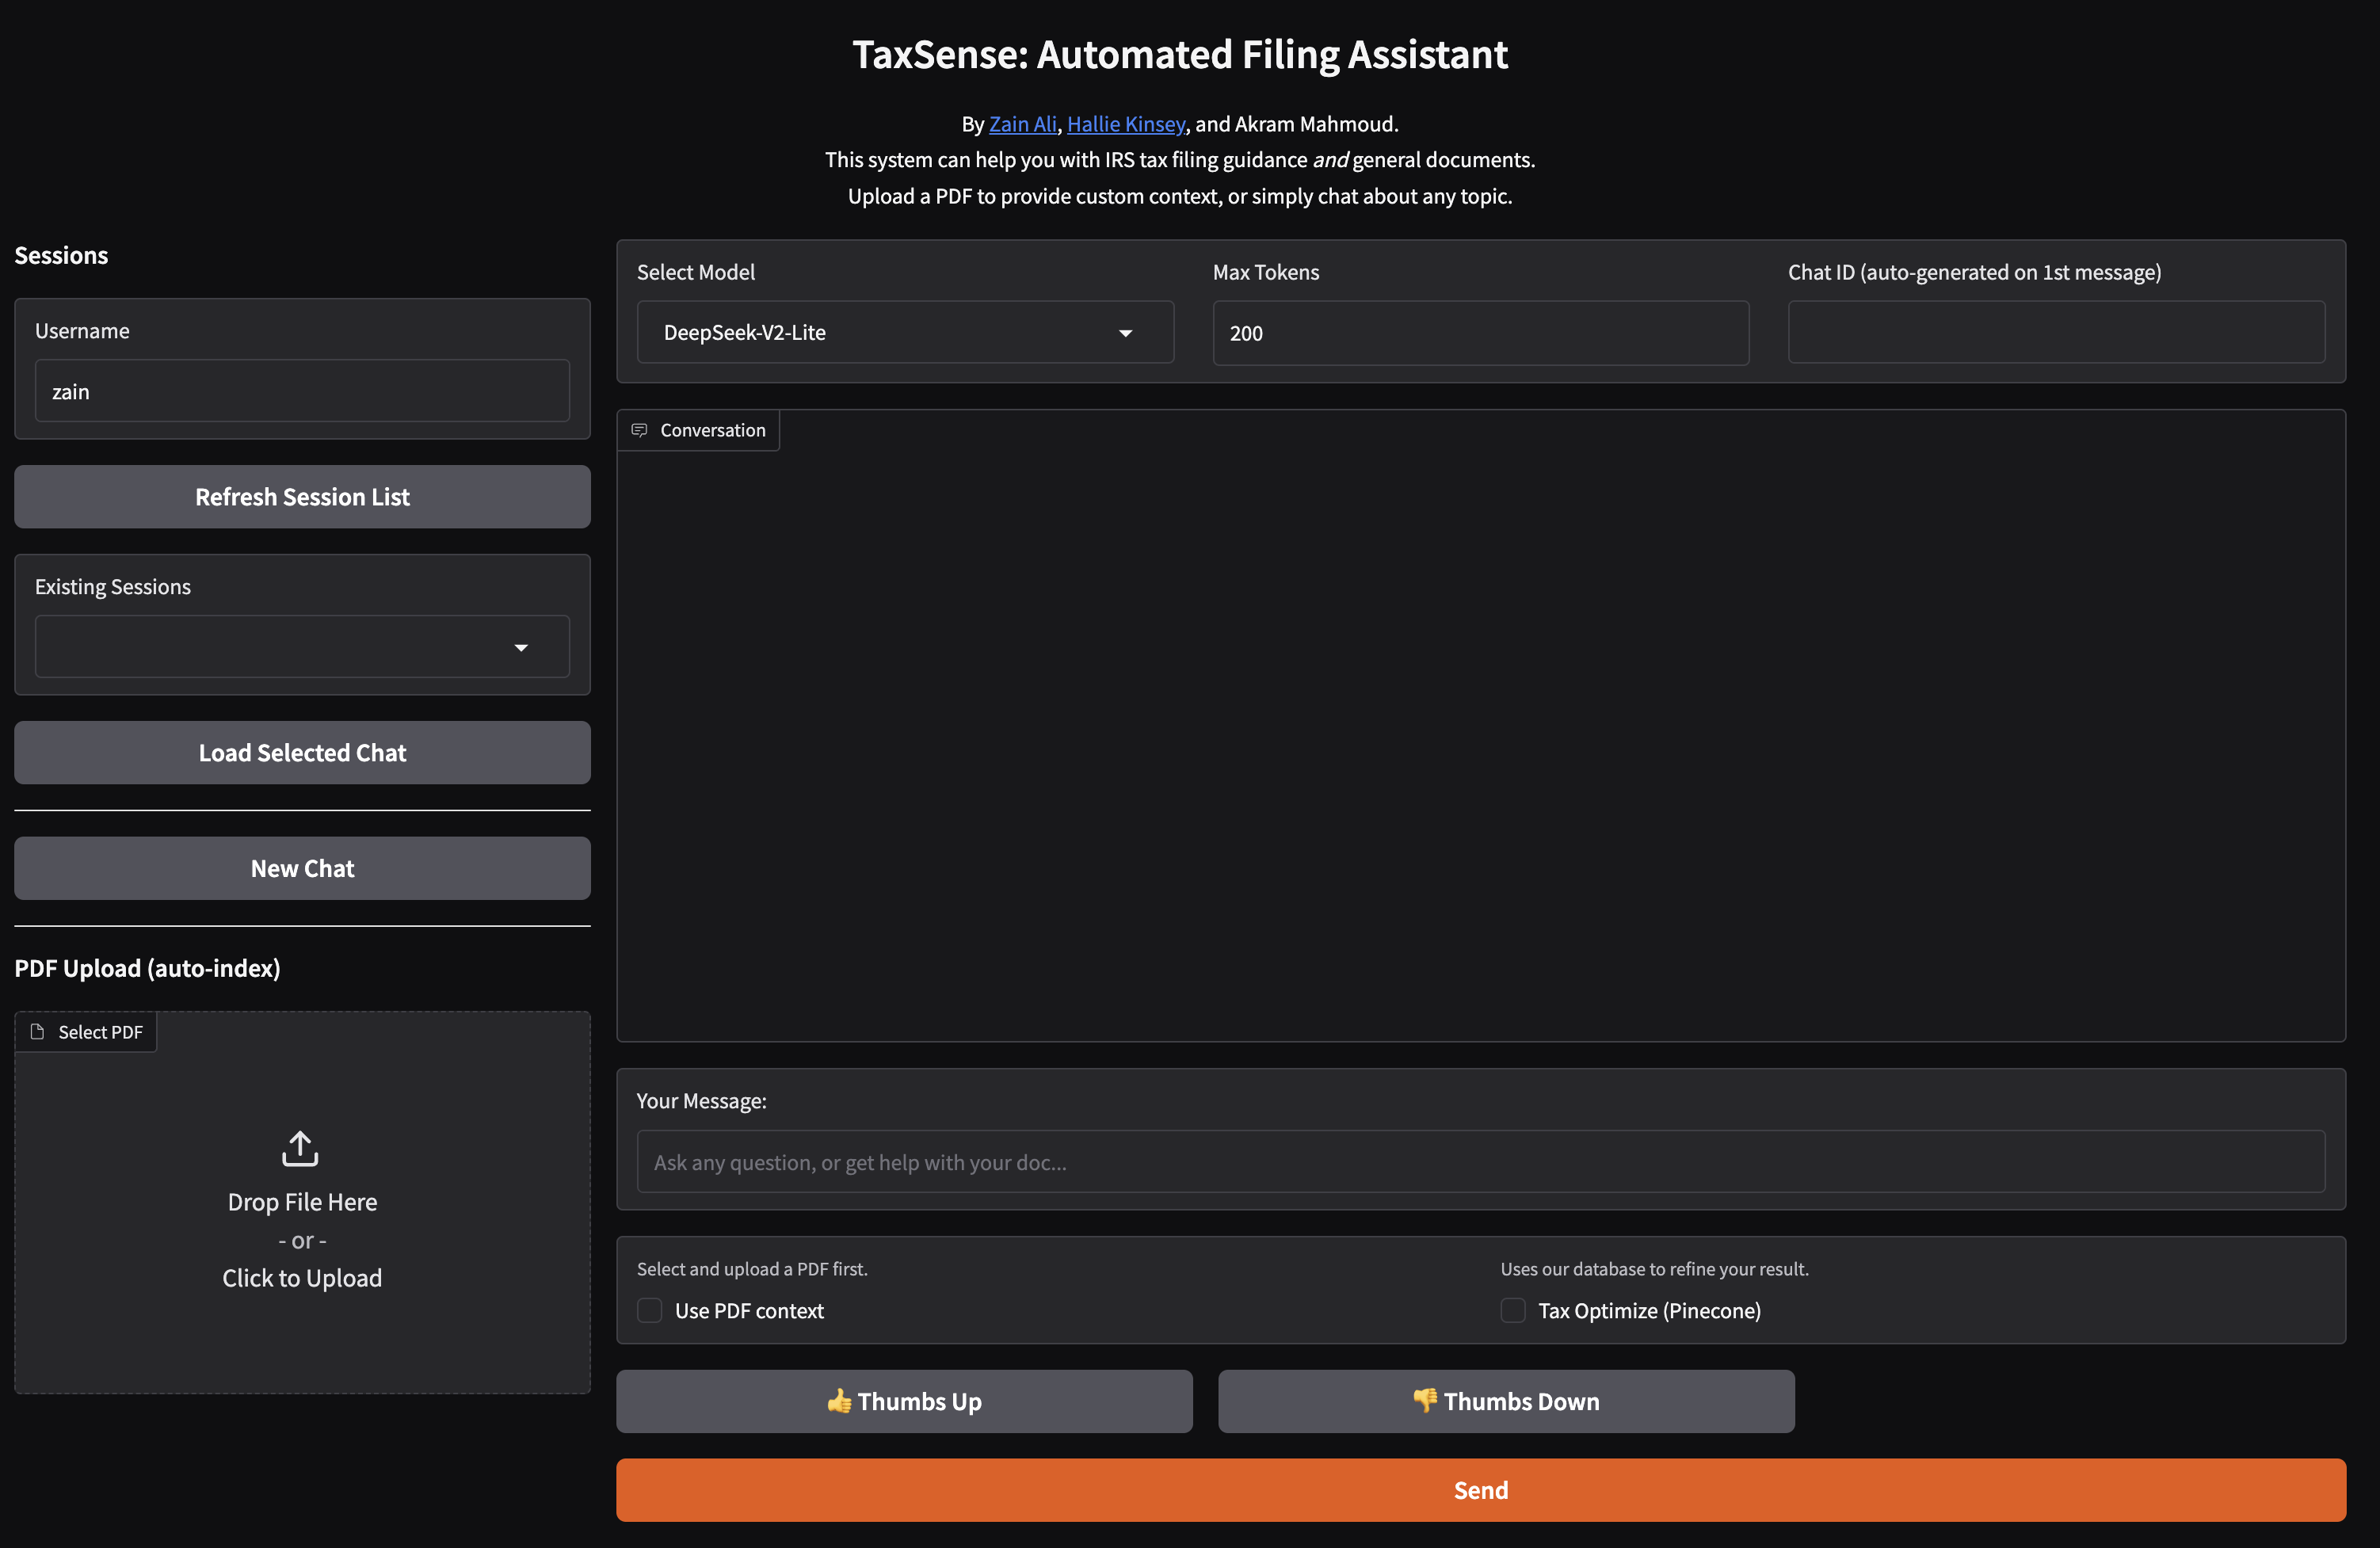

In [ ]:

display(Image.open("supporting_media/TaxSense-dashboard.png"))

The **TaxSense: Automated Filing Assistant** helps with IRS tax filing guidance and document-related queries. The dashboard offers several features to make tax-related assistance and document processing easier.  

### User Sessions Management  
- **Username Entry:** Set your username to track conversations.  
- **Refresh Sessions:** Update the session list with the latest chats.  
- **Existing Sessions:** Select a previous chat from the dropdown.  
- **Load Selected Chat:** Retrieve conversation history for a selected session.  
- **New Chat:** Start a new conversation.  

### PDF Upload and Contextual AI Assistance  
- **Upload a PDF:** Add a document to get AI-driven assistance based on its content.  
- **Auto-Indexing:** Extract and organize text from the uploaded PDF for analysis.  
- **Use PDF Context:** Enable this to let the assistant use information from your document for better responses.  

### Chat and AI Model Selection  
- **Select Model:** Choose from available AI models for responses.  
- **Max Tokens:** Set a limit for response length.  
- **Chat ID:** Automatically generated to track your conversation.  
- **Ask a Question:** Enter queries to get tax-related help.  

### Tax Optimization and AI Enhancements  
- **Tax Optimize (Pinecone):** Improve answers using external tax-related databases.  
- **Use PDF Context vs. Tax Optimize:** Only one of these can be enabled at a time for more accurate results.  

### Feedback and Chat Control  
- **Thumbs Up / Thumbs Down:** Provide feedback on the AI’s responses.  
- **Send Button:** Submit your question for assistance.  

### Backend Features Supporting the Dashboard  
- **Chat History Retrieval:** View past conversations.  
- **Tax-Specific AI Completions:** Get optimized responses for IRS tax-related questions.  
- **Pinecone Database Integration:** Improve AI-generated responses with extra tax-related sources.  
- **PDF Processing:** Extract useful information from uploaded documents to help with tax filing.  

You can upload a tax-related PDF and enable **Use PDF Context** for document-based responses or turn on **Tax Optimize** for insights from external tax databases.  

A live link for testing will be available on our GitHub. You can also check out a demo in the `README.md` file.

If you want to know how this way built, [go to `Frontend - The User Chat` section](#frontend---the-user-chat).


Here is the full final architecture of out system. there is also a [backend](#rest-of-backend) and an [admin](#admin-data-backup-sync-service) part. n this report, you will find a detailed account of the research, design, testing, and rationale behind every part of the system. There are supporting files and images; please feel free to check those out. 

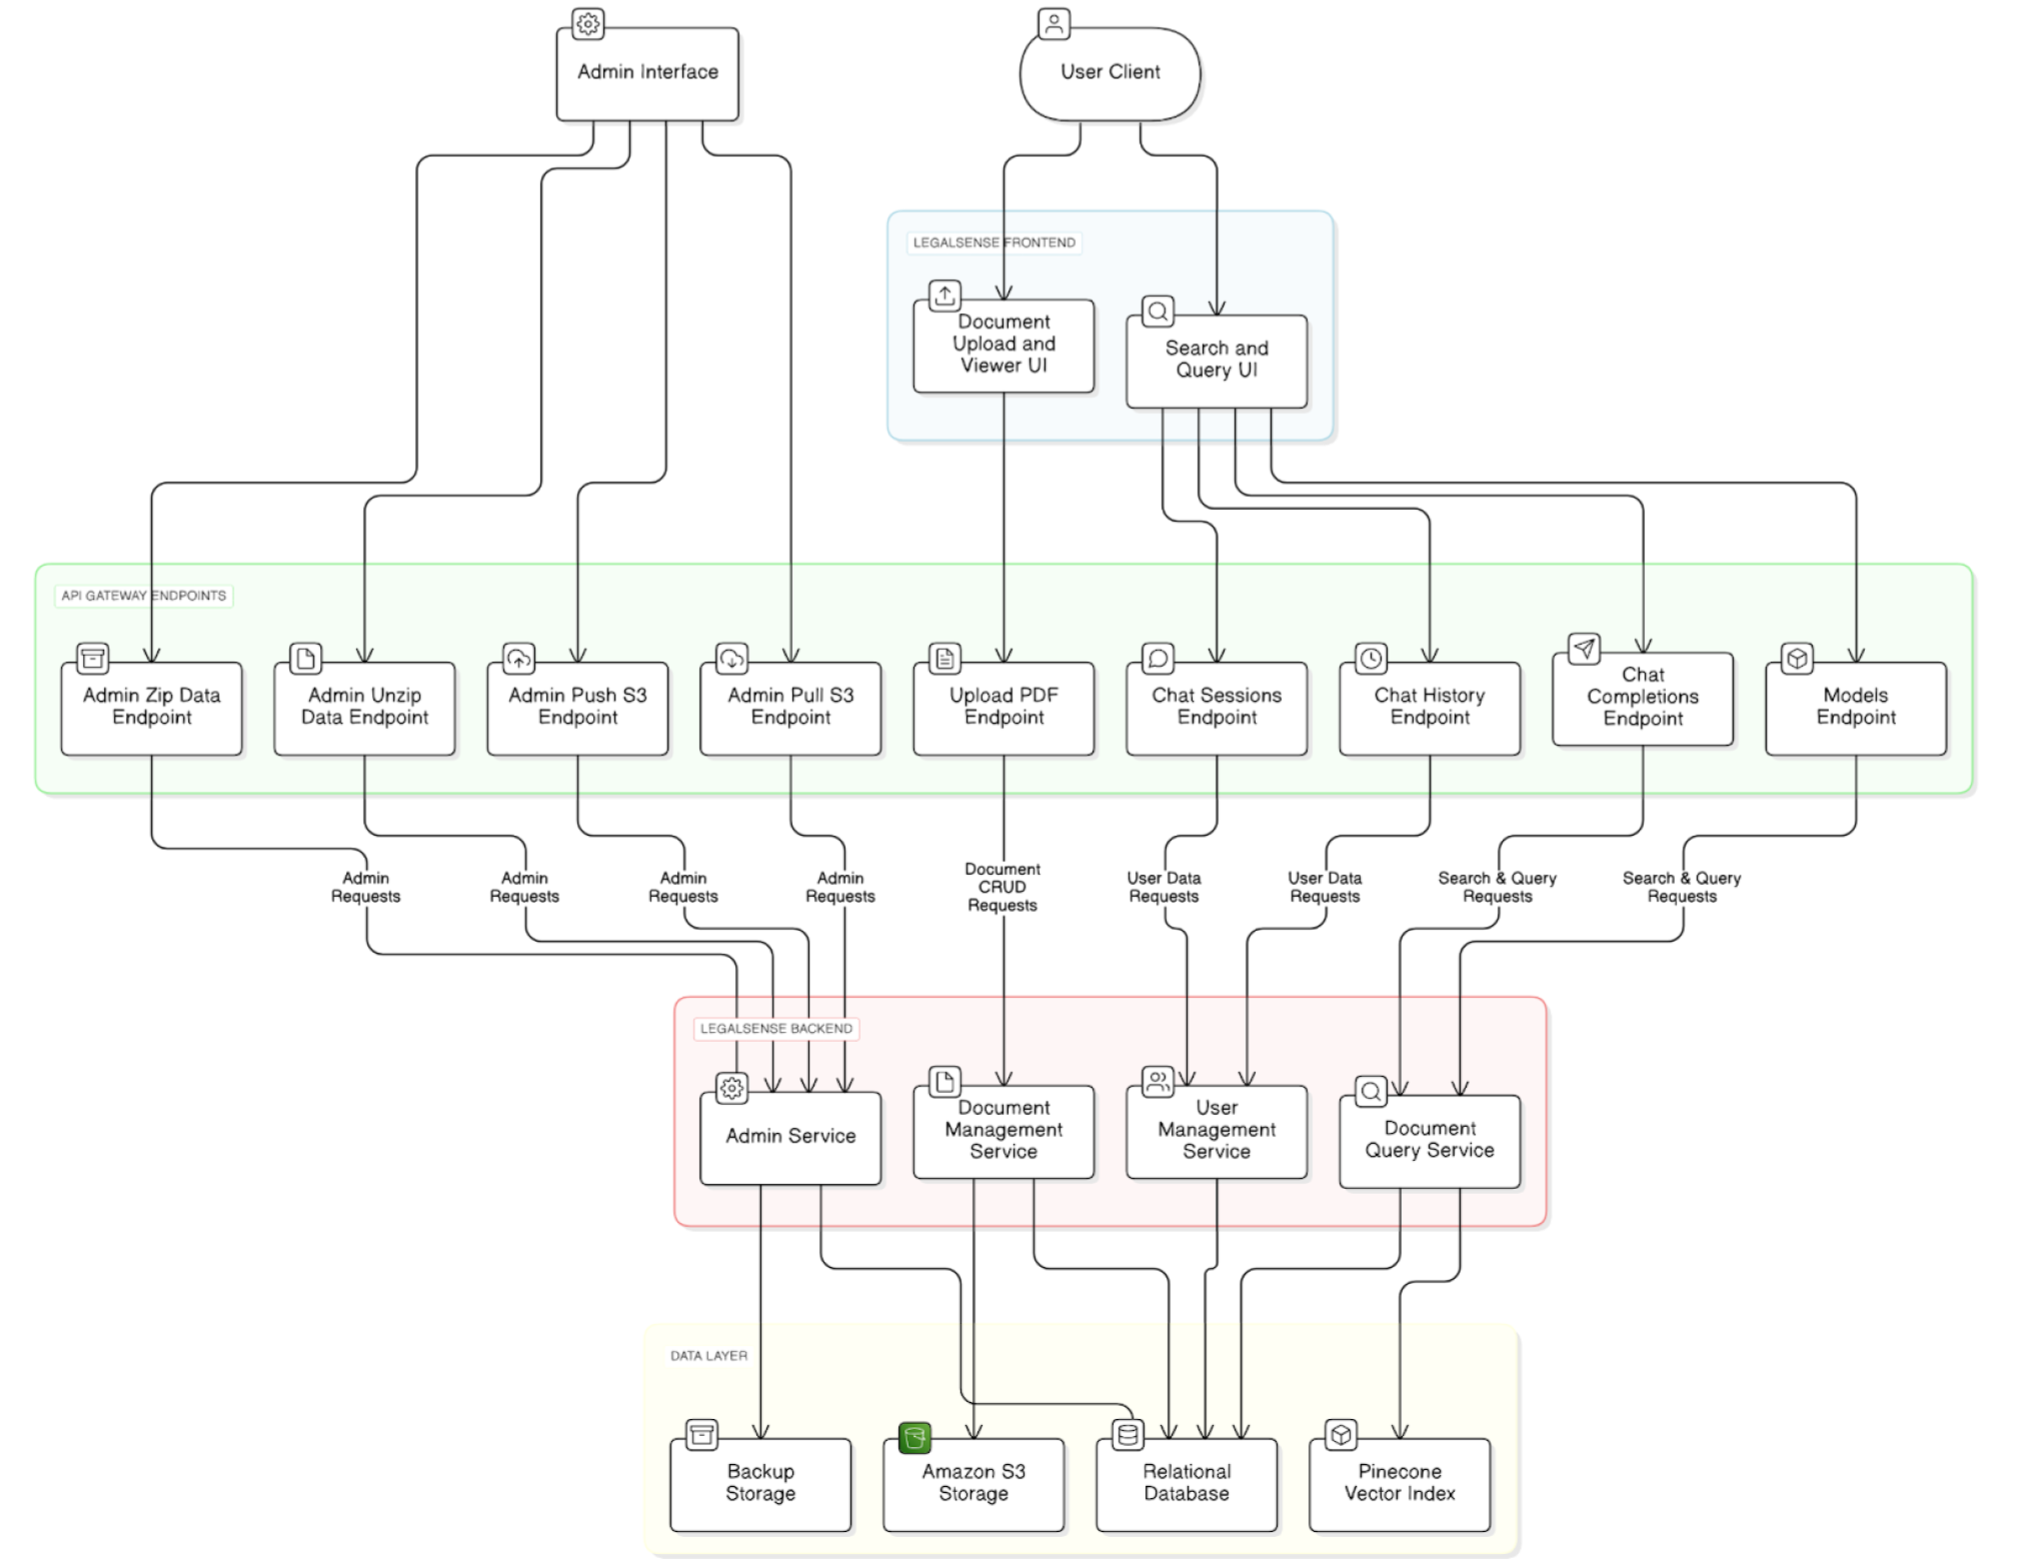

In [3]:
display(Image.open("supporting_media/TaxSense-architecture.png"))

Our initial plan for this project was quite advance, but we ran into alot of permission issues and had to resort to utilizing alot of local Jupyter notebook alternatives. 

## Data Collection

### Initial Realization

Our initial strategy was to locate an existing dataset that addressed our specific use case. However, after an extensive search, we found that no suitable dataset was available. We then considered web scraping as an alternative. After a detailed review of both the technical challenges and legal implications, we decided against scraping third-party websites due to explicit restrictions. For example:

- **Intuit (TurboTax):**  
  Intuit’s TurboTax terms explicitly prohibit any “unauthorized access” to their platform, including scraping or downloading content that isn’t owned by the user. This means using bots or scripts to extract data without proper permission is not allowed (https://www.intuit.com/legal/terms/en-us/turbotax/online-license/).

- **H&R Block:**  
  H&R Block’s online services agreement similarly bans any automated data extraction. Users are not permitted to harvest, scrape, or use any automated means (such as bots or spiders) to access their software and services or extract data, especially personal information, without consent (https://assist.hrblockonline.ca/TermsAndConditions.html#:~:text=If%20you%20breach%20any%20of,may%20be%20available%20to%20Block).

- **TaxAct:**  
  TaxAct’s Terms of Service include clear restrictions against using data mining, robots, artificial intelligence, or similar methods to extract data from their website. Their services are intended solely for personal tax preparation, and automated extraction of content such as Q&A is considered a breach of these terms (https://www.taxact.com/terms-of-service).

### Synthetic Data vs. RAG Approach

Another option we explored was generating synthetic data. Although synthetic data creation could have provided the necessary material, we encountered significant challenges—such as bias, hallucinations, and data quality concerns—which made this approach less attractive.

Ultimately, we determined that a Retrieval-Augmented Generation (RAG) approach would be the best course of action. Rather than fine-tuning on potentially limited or noisy data, the RAG framework allows us to map final answers directly to verified reference materials. This method not only saves valuable development time—since fine-tuning requires hand-creating and curating datasets—but also ensures that our model’s outputs are traceable to reliable sources.

### Model Integration and Architecture

Since most of the models we can run are relatively small or quantized, incorporating a larger model into our workflow allows us to add significant value. Our approach involves using multiple architectures to extract tax-related questions and verify their answers. This ensemble method helps counteract individual model biases and provides a more robust foundation for the final expert-level tax advisor model that we plan to fine-tune.

### Tuning for Context and Bias Reduction

For tuning, we are planning to focus on improving contextual awareness and removing bias by extracting information from a variety of sources. As part of our quality assurance process, we reviewed a random sample of 32 tax-related questions to check for any immediate and major hallucinations—and found none.



### Data Collection Responses

Below is an organized summary of the responses received from various models during our evaluation process. Each model’s output has been annotated with a placeholder to indicate where the detailed responses will be integrated:

#### GPT4o (Online Search Feature):

Prompt to GPT4o using online scraping feature: Research online and give me the top 20 tax questions that most people ask, along with the answers to those questions. 

##### Response:

```

Navigating the complexities of the U.S. tax system can be challenging. Below are 20 common tax questions along with concise answers to help clarify these topics:

1. **How can I reduce my tax bill?**
   - To lower your tax liability, consider maximizing deductions and credits, contributing to retirement accounts, and utilizing tax-efficient investments. Consult a tax professional for personalized strategies. citeturn0search8

2. **What deductions am I eligible for?**
   - Eligibility for deductions varies based on individual circumstances. Common deductions include mortgage interest, state and local taxes, charitable contributions, and medical expenses exceeding a certain threshold. citeturn0search8

3. **What's the difference between marginal and effective tax rates?**
   - The marginal tax rate is the rate applied to your next dollar of income, while the effective tax rate is the average rate you pay on your total taxable income. citeturn0search8

4. **Which is better: a tax credit or a tax deduction?**
   - A tax credit directly reduces your tax liability dollar-for-dollar, whereas a deduction lowers your taxable income. Generally, credits are more beneficial. citeturn0search8

5. **Can I deduct medical expenses?**
   - Yes, you can deduct unreimbursed medical expenses that exceed 7.5% of your adjusted gross income, provided you itemize your deductions. citeturn0search8

6. **Should I itemize deductions or take the standard deduction?**
   - You should itemize if your allowable deductions exceed the standard deduction for your filing status. Otherwise, the standard deduction may be more beneficial. citeturn0search8

7. **How do tax brackets work?**
   - The U.S. tax system is progressive; income is taxed at increasing rates as it moves into higher brackets. Each bracket applies to a specific range of income. citeturn0search5

8. **What is the Earned Income Tax Credit (EITC) and how do I claim it?**
   - The EITC is a refundable credit for low to moderate-income earners. Eligibility depends on income and number of qualifying children. To claim, file a tax return even if you owe no tax. citeturn0search1

9. **Are unemployment benefits taxable?**
   - Yes, unemployment benefits are generally considered taxable income at the federal level and may also be taxable at the state level. citeturn0search1

10. **How are my investment gains taxed?**
    - Short-term capital gains (on assets held less than a year) are taxed as ordinary income, while long-term gains benefit from lower tax rates. citeturn0search0

11. **Do I pay taxes on investments if I don't sell them?**
    - Generally, you pay taxes on dividends and interest earned, even if you don't sell the investment. Capital gains taxes apply only upon sale. citeturn0search0

12. **What income is taxable?**
    - Taxable income includes wages, salaries, bonuses, interest, dividends, rental income, and other earnings. Some income, like certain Social Security benefits, may be partially taxable. citeturn0search0

13. **When are taxes due?**
    - Federal income tax returns are typically due on April 15. If this date falls on a weekend or holiday, the deadline is the next business day. citeturn0search2

14. **What happens if I don't file my taxes?**
    - Failure to file can result in penalties, interest on unpaid taxes, and potential legal action. It's advisable to file even if you can't pay immediately. citeturn0search2

15. **How do I notify the IRS of an address change?**
    - You can inform the IRS by filing Form 8822, using your new address on your tax return, or sending a signed written statement to the address where you filed your last return. citeturn0search7

16. **Can I claim my boyfriend/girlfriend as a dependent?**
    - Possibly, if they meet the criteria for a qualifying relative, including residency, income limits, and you providing over half of their support. citeturn0search1

17. **Are moving expenses tax-deductible?**
    - As of the Tax Cuts and Jobs Act of 2017, moving expenses are generally not deductible, except for active-duty military members moving due to a military order. citeturn0search1

18. **How do I check the status of my tax refund?**
    - You can check your refund status using the "Where's My Refund?" tool on the IRS website or via the IRS2Go mobile app. citeturn0news9

19. **What is the Alternative Minimum Tax (AMT)?**
    - The AMT is a parallel tax system ensuring that high-income individuals pay a minimum amount of tax, disallowing certain deductions and credits. citeturn0search10

20. **How long should I keep tax records?**
    - It's recommended to keep tax records for at least three years from the date you filed your return or two years from the date you paid the tax, whichever is later. citeturn0search10
```

#### ChatGPT o3-mini-high:  

Prompt to ChatGPT o3-mini-high: give me 20 more of the tax question. Some deep ones. search online or just if you know them

##### Response:

```
| Question | Answer |
|----------|--------|
| **What is the difference between tax avoidance and tax evasion?** | Tax avoidance is the legal use of tax laws, deductions, credits, and strategies to minimize tax liability. Tax evasion, on the other hand, is the illegal act of misrepresenting or concealing information to reduce taxes owed. |
| **How does the Alternative Minimum Tax (AMT) work for high-income taxpayers?** | The AMT is a parallel tax system designed to ensure that high-income taxpayers pay a minimum tax. It limits or disallows many deductions and credits available under the regular tax system, requiring taxpayers to calculate their liability under both methods and pay the higher amount. |
| **How do tax treaties mitigate double taxation on international income?** | Tax treaties are agreements between countries that allocate taxing rights on cross-border income. They help prevent the same income from being taxed twice by providing methods such as tax credits, exemptions, or reduced withholding rates on dividends, interest, and royalties. |
| **How is cost basis determined for capital gains, and what adjustments are commonly made?** | The cost basis is generally the original purchase price plus any associated acquisition costs. Adjustments may include depreciation, stock splits, reinvested dividends, or return of capital. The adjusted basis is used to compute the gain or loss when the asset is sold. |
| **What are the implications of the passive activity loss rules for rental real estate investments?** | Passive activity loss rules restrict the deduction of losses from rental and other passive activities against non-passive income. Losses that exceed the limit cannot be deducted in the current year but may be carried forward to offset future passive income or become deductible when the activity is sold. |
| **How are self-employment taxes calculated, and what strategies can reduce their impact?** | Self-employment taxes are calculated on net earnings at a combined rate of 15.3% (12.4% for Social Security and 2.9% for Medicare). Taxpayers can reduce the impact by deducting half of the self-employment tax as an adjustment to income and contributing to retirement plans that lower taxable income. |
| **What is the Qualified Business Income (QBI) deduction and what limitations apply?** | The QBI deduction allows eligible owners of pass-through entities to deduct up to 20% of their qualified business income. Limitations include income thresholds, restrictions for specified service trades or businesses, and additional requirements involving W-2 wages and the basis of qualified property. |
| **How does the tax treatment of cryptocurrency transactions differ from traditional investments?** | Cryptocurrencies are treated as property for tax purposes. This means that transactions such as sales or exchanges trigger capital gains or losses calculated based on the difference between the cost basis and the sale price. Taxpayers must keep detailed records, and special rules may apply for frequent trading or mining activities. |
| **What are the tax implications of stock options, and how do ISOs differ from NSOs?** | Incentive Stock Options (ISOs) can qualify for favorable tax treatment if holding requirements are met, potentially resulting in capital gains on sale. However, exercising ISOs may trigger the AMT. Non-Qualified Stock Options (NSOs) are taxed as ordinary income at the time of exercise, based on the difference between the exercise price and the fair market value. |
| **How does depreciation recapture affect the sale of depreciated property?** | When selling depreciated property, the portion of the gain attributable to depreciation deductions previously taken is "recaptured" and taxed as ordinary income rather than at the lower capital gains rate. This rule applies mainly to business or rental property and ensures that depreciation benefits are partially reversed. |
| **How does a Section 1031 like-kind exchange work and what are its limitations post-TCJA?** | A Section 1031 exchange allows taxpayers to defer capital gains tax on the sale of certain investment properties by reinvesting the proceeds in similar (like-kind) property. Post-TCJA, the exchange is limited to real property and must adhere to strict identification and timing rules to qualify for deferral. |
| **What are the tax implications of receiving foreign income and using the Foreign Tax Credit?** | U.S. taxpayers must report their worldwide income, including foreign income. The Foreign Tax Credit helps prevent double taxation by allowing a credit for taxes paid to a foreign government. The credit is limited to the proportion of U.S. tax attributable to foreign income, and any excess foreign taxes may be carried back or forward. |
| **How does the cancellation of debt (COD) income work and what is the insolvency exception?** | Generally, canceled debt is considered taxable income. However, if a taxpayer is insolvent—meaning their liabilities exceed their assets—they may exclude canceled debt from income up to the amount of insolvency. Proper documentation and filing of Form 982 are required to claim this exception. |
| **How do installment sales work for deferring gain on property sales?** | An installment sale allows the seller to spread the recognition of gain over the period in which the payments are received. Each installment includes a portion of the gain based on the gross profit ratio. This method can help spread out tax liability over several years, potentially lowering overall tax rates. |
| **What is the doctrine of economic substance and how does it affect tax planning?** | The economic substance doctrine requires that transactions have a substantial non-tax purpose beyond merely generating tax benefits. If a transaction is found to lack economic substance, the IRS may disregard it for tax purposes, which can lead to disallowed deductions or credits and potential penalties. |
| **How do tax loss carryforwards and carrybacks work, and what limitations exist?** | Tax loss carryforwards allow a taxpayer to apply a net operating loss (NOL) to offset taxable income in future years. Some losses may also be carried back to prior years for a refund. Limitations include percentage caps on how much of a loss can be used in a given year and expiration periods for carrying losses forward. |
| **What are the tax implications of converting a business entity, such as from an LLC to an S corporation?** | Converting a business entity can trigger tax consequences such as recognition of gain on appreciated assets, changes in self-employment tax treatment, and adjustments in the allocation of income and losses among owners. The conversion process must be planned carefully to minimize unintended tax liabilities. |
| **How does the treatment of charitable contributions differ when itemizing deductions versus taking the standard deduction?** | When itemizing, taxpayers can deduct qualified charitable contributions subject to AGI limits and documentation requirements. Those taking the standard deduction cannot separately deduct charitable contributions unless there is a special above-the-line provision available. |
| **How are fringe benefits taxed, and what exceptions exist?** | Fringe benefits are generally taxable to employees unless specifically excluded by law. Common exceptions include employer-provided health insurance, certain transportation benefits, and de minimis benefits (small perks with minimal value). The IRS provides specific valuation rules for various benefits. |
| **How does the tax treatment differ for nonresident aliens compared to U.S. residents?** | Nonresident aliens are typically taxed only on income that is effectively connected with a U.S. trade or business and on certain fixed, determinable, annual, or periodic (FDAP) U.S.-source income, often at a flat withholding rate. U.S. residents are taxed on their worldwide income and face different filing requirements and deductions. |
```



#### Claude 3.7 Sonnet: 


Prompt to Claude 3.7 Sonnet: give me 40 questions related to tax, not too unique ones and the answers to it in detail in a table


##### Response:

```
# 40 Common Tax Questions and Detailed Answers

| Question | Detailed Answer |
|----------|----------------|
| 1. What is the difference between a tax credit and a tax deduction? | A tax credit directly reduces your tax liability dollar-for-dollar. If you owe $1,000 in taxes and receive a $200 tax credit, your tax bill becomes $800. A tax deduction, on the other hand, reduces your taxable income. If you have a $1,000 deduction in the 22% tax bracket, it reduces your taxes by $220 (22% of $1,000). Credits are generally more valuable than deductions of the same amount. |
| 2. What is the standard deduction for 2024? | For the 2024 tax year (filing in 2025), the standard deduction is $14,600 for single filers and married filing separately, $29,200 for married filing jointly, and $21,900 for heads of household. These amounts are adjusted annually for inflation. |
| 3. What is the difference between itemized deductions and the standard deduction? | The standard deduction is a fixed amount that reduces your taxable income based on your filing status. Itemized deductions are specific expenses you can deduct, such as mortgage interest, charitable donations, medical expenses, and state and local taxes (up to certain limits). You should choose whichever method gives you the larger deduction. |
| 4. How long should I keep tax records? | The IRS recommends keeping tax returns and supporting documents for at least 3 years after filing, as this is generally the statute of limitations for audits. However, if you underreport income by more than 25%, the IRS has 6 years to audit you. For employment tax records, keep them for at least 4 years. For property records, keep them until you dispose of the property plus 3-7 years. |
| 5. What is the capital gains tax rate? | For 2024, long-term capital gains (assets held over one year) are taxed at 0% for incomes up to $47,025 (single) or $94,050 (married filing jointly), 15% for incomes up to $518,900 (single) or $583,750 (married filing jointly), and 20% for incomes above those thresholds. Short-term capital gains (assets held one year or less) are taxed as ordinary income. |
| 6. How do I calculate my tax bracket? | Tax brackets are based on your taxable income (after deductions and adjustments). For 2024, there are seven federal income tax brackets: 10%, 12%, 22%, 24%, 32%, 35%, and 37%. Your taxable income falls into specific brackets, with higher rates applying only to the portion of income that exceeds each threshold, creating a progressive tax system. |
| 7. What is the deadline for filing taxes? | For most individuals, federal income tax returns are due by April 15th each year. If April 15th falls on a weekend or holiday, the deadline shifts to the next business day. You can request a six-month extension using Form 4868, but this only extends the filing deadline—not the deadline for paying any taxes owed. |
| 8. What is the penalty for filing taxes late? | The penalty for filing late is typically 5% of the unpaid taxes for each month or part of a month that the return is late, up to 25%. If you file more than 60 days late, the minimum penalty is $485 (for returns due in 2024) or 100% of your unpaid tax, whichever is smaller. There's also a separate penalty for paying late: 0.5% of unpaid taxes per month, up to 25%. |
| 9. What tax forms do I need to file? | Most individuals use Form 1040 for federal income taxes. Additional schedules may be required depending on your situation: Schedule A for itemized deductions, Schedule B for interest and dividends, Schedule C for self-employment income, Schedule D for capital gains and losses, Schedule E for rental income, and Schedule SE for self-employment tax calculation. |
| 10. How do I check my tax refund status? | You can check your federal tax refund status using the "Where's My Refund?" tool on the IRS website or the IRS2Go mobile app. You'll need your Social Security number, filing status, and exact refund amount. Most refunds are issued within 21 days of electronic filing, though some may take longer due to errors, identity verification, or certain tax credits claimed. |
| 11. What is the Earned Income Tax Credit (EITC)? | The EITC is a refundable tax credit for low to moderate-income working individuals and couples, particularly those with children. For 2024, the maximum credit ranges from $600 (no qualifying children) to $7,430 (three or more qualifying children). Eligibility and credit amount depend on filing status, income, and number of qualifying children. |
| 12. Are unemployment benefits taxable? | Yes, unemployment benefits are generally considered taxable income at the federal level. You should receive Form 1099-G showing the amount of unemployment compensation you received during the tax year. However, state taxation of unemployment benefits varies by state. |
| 13. How do I report cryptocurrency transactions on my taxes? | Cryptocurrency transactions are reported on Schedule D and Form 8949. You must report any capital gains or losses from buying, selling, or exchanging cryptocurrency. Mining rewards and receiving crypto as payment for goods or services are typically reported as ordinary income. The IRS considers crypto as property for tax purposes, not currency. |
| 14. What is the Child Tax Credit? | The Child Tax Credit for 2024 is worth up to $2,000 per qualifying child under age 17, with up to $1,600 being refundable (as the Additional Child Tax Credit). The credit begins to phase out for single filers with modified AGI above $200,000 and married filing jointly above $400,000. |
| 15. What is the tax treatment for Health Savings Accounts (HSAs)? | HSAs offer triple tax advantages: contributions are tax-deductible, growth is tax-free, and withdrawals for qualified medical expenses are tax-free. For 2024, the contribution limit is $4,150 for individual coverage and $8,300 for family coverage, with an additional $1,000 catch-up contribution allowed for those 55 or older. |
| 16. How do 401(k) contributions affect my taxes? | Traditional 401(k) contributions are made pre-tax, reducing your taxable income for the year. For example, if you earn $60,000 and contribute $6,000 to your 401(k), your taxable income becomes $54,000. The 2024 contribution limit is $23,000, with an additional $7,500 catch-up contribution allowed for those 50 or older. Roth 401(k) contributions are made after-tax but grow tax-free. |
| 17. What home expenses are tax deductible? | For most homeowners, mortgage interest on up to $750,000 of acquisition debt (for homes purchased after Dec. 15, 2017) and property taxes (up to $10,000 combined with state and local income taxes) are deductible if you itemize. Home office expenses may be deductible for self-employed individuals using the exclusive area regularly for business. |
| 18. How are Social Security benefits taxed? | Social Security benefits may be partially taxable depending on your "combined income" (adjusted gross income + nontaxable interest + half of your Social Security benefits). For individuals with combined income between $25,000 and $34,000, up to 50% of benefits may be taxable. Above $34,000, up to 85% may be taxable. For married filing jointly, the thresholds are $32,000 and $44,000. |
| 19. What is the Gift Tax exclusion amount? | For 2024, you can give up to $18,000 per recipient per year without filing a gift tax return or counting against your lifetime estate and gift tax exemption. Married couples can split gifts, allowing up to $36,000 per recipient annually. Payments made directly to educational institutions or medical providers are exempt from gift tax regardless of amount. |
| 20. How do I handle taxes for a side gig or freelance work? | Income from side gigs or freelance work is reported on Schedule C. You're responsible for paying self-employment tax (15.3% for Social Security and Medicare) on net earnings over $400, reported on Schedule SE. You may need to make quarterly estimated tax payments using Form 1040-ES if you expect to owe $1,000 or more in taxes. Keep detailed records of business expenses for potential deductions. |
| 21. What education expenses are tax deductible or eligible for credits? | The American Opportunity Credit provides up to $2,500 per eligible student for the first four years of higher education. The Lifetime Learning Credit offers up to $2,000 per tax return for undergraduate, graduate, or professional courses. Student loan interest (up to $2,500) may be deductible. Qualified tuition and related expenses may be deductible under the Tuition and Fees Deduction. |
| 22. How does marriage affect taxes? | Marriage can create a "marriage bonus" or "marriage penalty" depending on your incomes. When spouses have similar incomes, especially if both are high earners, they may pay more tax filing jointly than they would as singles ("marriage penalty"). When incomes are disparate, joint filing often results in lower taxes ("marriage bonus"). Marriage affects tax brackets, standard deduction, and various credits and deductions. |
| 23. What is the Alternative Minimum Tax (AMT)? | The AMT is a parallel tax system designed to ensure that taxpayers with substantial income don't avoid paying taxes through deductions and credits. It has its own set of rules for calculating taxable income with fewer available deductions. You calculate tax under both regular and AMT systems and pay the higher amount. The AMT exemption for 2024 is $85,700 for singles and $133,300 for married filing jointly. |
| 24. How are dividends taxed? | Qualified dividends are taxed at the same preferential rates as long-term capital gains (0%, 15%, or 20%, depending on your income). Non-qualified dividends are taxed as ordinary income. Dividends from most U.S. corporations and certain foreign corporations are generally qualified if you've held the stock for more than 60 days during the 121-day period beginning 60 days before the ex-dividend date. |
| 25. What are the tax implications of working remotely in a different state? | Working remotely across state lines can create multi-state tax obligations. You may owe income tax to both your state of residence and the state where your employer is located, though tax credits typically prevent double taxation. Some states have "convenience of employer" rules that tax nonresident telecommuters. During COVID-19, some states implemented temporary relief provisions. |
| 26. What charitable donations are tax deductible? | Donations to qualified tax-exempt organizations (churches, nonprofit educational organizations, etc.) are deductible if you itemize. For cash donations, you can deduct up to 60% of your adjusted gross income (AGI). For property donations, the limit is typically 30% of AGI. Always get a receipt for donations of $250 or more, and special forms may be required for donations over $500. |
| 27. How do I claim a home office deduction? | Self-employed individuals can claim home office deductions using either the regular method (calculating actual expenses) or simplified method ($5 per square foot, up to 300 square feet). The space must be used regularly and exclusively for business. W-2 employees generally cannot claim home office deductions for tax years 2018-2025 due to the suspension of the miscellaneous itemized deductions. |
| 28. What is depreciation recapture? | Depreciation recapture occurs when you sell a depreciable asset (like rental property) for more than its depreciated value. The portion of your gain attributable to depreciation is taxed as ordinary income, up to 25%, rather than at capital gains rates. This prevents taxpayers from claiming ordinary deductions while receiving the benefit of lower capital gains rates on sale. |
| 29. How do I report rental income and expenses? | Rental income and expenses are reported on Schedule E. Deductible expenses include mortgage interest, property taxes, insurance, maintenance, utilities, management fees, and depreciation of the property. Rental losses may be deductible up to $25,000 against other income if your modified AGI is less than $100,000 and you actively participate in the rental activity. |
| 30. What is the Net Investment Income Tax (NIIT)? | The NIIT is a 3.8% tax on net investment income (interest, dividends, capital gains, rental income, royalties, etc.) that applies to individuals with modified adjusted gross income exceeding $200,000 (single) or $250,000 (married filing jointly). It's calculated on the lesser of your net investment income or the amount by which your MAGI exceeds the threshold. |
| 31. How are retirement account withdrawals taxed? | Traditional IRA and 401(k) withdrawals are generally taxed as ordinary income. Roth IRA qualified distributions (after age 59½ and account open for 5+ years) are tax-free. Early withdrawals (before age 59½) may incur a 10% penalty in addition to regular income tax, though exceptions exist. Required Minimum Distributions (RMDs) must begin at age 73 (as of 2024) for traditional accounts. |
| 32. What is the tax treatment for stock options? | For Non-Qualified Stock Options (NQSOs), you pay ordinary income tax on the difference between the grant price and exercise price when you exercise the option. For Incentive Stock Options (ISOs), you generally don't pay tax upon exercise, but the difference may trigger Alternative Minimum Tax. When you sell the stock, you'll pay capital gains tax on any additional appreciation. |
| 33. How do I deduct medical expenses? | Medical expenses exceeding 7.5% of your adjusted gross income are deductible if you itemize. Eligible expenses include costs for diagnosis, treatment, prevention, insurance premiums (if not pre-tax), prescription drugs, and certain long-term care expenses. Cosmetic procedures, non-prescription drugs, and general health products typically don't qualify. |
| 34. What is the Saver's Credit? | The Saver's Credit (officially the Retirement Savings Contributions Credit) provides a tax credit of up to $1,000 ($2,000 for married filing jointly) for low and moderate-income taxpayers who contribute to retirement accounts. For 2024, the credit phases out for single filers with AGI above $24,000 and married filing jointly above $48,000. The credit amount is 10%, 20%, or 50% of contributions, depending on income. |
| 35. How do I report stock sales on my tax return? | Stock sales are reported on Schedule D and Form 8949. Your broker should provide Form 1099-B with details of your transactions. You'll need to report the sale date, purchase date, cost basis, sale proceeds, and gain or loss. Holding periods determine whether gains are short-term (ordinary income rates) or long-term (preferential capital gains rates). |
| 36. What is the Foreign Tax Credit? | The Foreign Tax Credit helps U.S. taxpayers avoid double taxation on foreign-source income by providing a credit for foreign taxes paid. You can either take a deduction for foreign taxes paid (on Schedule A) or a credit (using Form 1116, though Form 1040 filers with only passive foreign income may qualify for a simplified procedure). The credit is generally more beneficial than the deduction. |
| 37. What are the tax implications of cancellation of debt? | Cancelled debt is generally considered taxable income. If a creditor forgives or cancels $600 or more of debt, they'll issue Form 1099-C. However, exceptions exist for certain bankruptcy cases, insolvency, qualified principal residence indebtedness, qualified farm debt, and certain student loans. The tax treatment depends on your specific circumstances and the type of debt. |
| 38. How do I report gambling winnings and losses? | All gambling winnings are reportable as "Other Income" on Form 1040. Casinos and other payers may provide Form W-2G for certain winnings. Gambling losses are deductible only if you itemize deductions and only up to the amount of your winnings. Keep detailed records of both winnings and losses, including dates, locations, types of gambling, and amounts won or lost. |
| 39. What is the tax treatment for Health Flexible Spending Arrangements (FSAs)? | Health FSA contributions are made pre-tax through employer plans, reducing your taxable income. For 2024, the contribution limit is $3,200. Unlike HSAs, FSAs generally follow a "use it or lose it" rule, though employers may offer either a grace period of up to 2.5 months or allow carrying over up to $640 to the next year. Withdrawals for qualified medical expenses are tax-free. |
| 40. How are inherited assets taxed? | Inherited assets generally receive a "step-up" in basis to their fair market value on the date of the original owner's death, eliminating capital gains tax on appreciation that occurred during the deceased's lifetime. When you eventually sell the asset, you'll only pay capital gains tax on appreciation since inheritance. Some inherited retirement accounts have specific required distribution rules that affect taxation. |
```


#### Llama 3.1-405B:


Prompt to  Llama 3.1-405B: give me 40 questions related to tax, not too unique ones and the answers to it in detail in a table, be detailed

##### Response:

```
Here are the 40 tax-related questions with detailed answers:
Tax-Related Questions and Answers

Question #	Question	Answer
1	What is the deadline for filing individual tax returns?	The deadline for filing individual tax returns is April 15th of each year, unless an extension is filed using Form 4868, which grants an automatic six-month extension to October 15th.
| 2 | What is the standard deduction for single filers? | The standard deduction for single filers is $13,850 for tax year 2023. This amount is adjusted annually for inflation. |
| 3 | What is the standard deduction for married couples filing jointly? | The standard deduction for married couples filing jointly is $27,700 for tax year 2023. This amount is also adjusted annually for inflation. |
| 4 | What is the tax rate for long-term capital gains? | Long-term capital gains are taxed at 0%, 15%, or 20% depending on income level. For tax year 2023, the 0% rate applies to taxable income up to $44,625 for single filers and $89,250 for joint filers. The 15% rate applies to taxable income between $44,626 and $492,300 for single filers and $89,251 and $553,850 for joint filers. The 20% rate applies to taxable income above $492,300 for single filers and $553,850 for joint filers. |
| 5 | Can I deduct mortgage interest on my tax return? | Yes, you can deduct mortgage interest on your primary residence and/or second home, up to a total of $750,000 ($375,000 for married filing separately). You must itemize deductions on Schedule A to claim this deduction. |
| 6 | What is the earned income tax credit (EITC)? | The EITC is a refundable tax credit for low-income working individuals and families. For tax year 2023, the credit ranges from $538 to $6,728 depending on income level, filing status, and number of qualifying children. |
| 7 | Can I claim a dependent on my tax return? | Yes, you can claim a dependent on your tax return if they meet certain tests, such as the qualifying child or qualifying relative test. You may be eligible for the dependent exemption, child tax credit, or other benefits. |
| 8 | What is the child tax credit? | The child tax credit is a non-refundable tax credit of up to $2,000 per child under age 17. The credit begins to phase out at $400,000 for joint filers and $200,000 for single filers. |
| 9 | Do I need to file a tax return if I'm self-employed? | Yes, you need to file a tax return if your net earnings from self-employment are $400 or more. You'll report your business income and expenses on Schedule C and pay self-employment tax on your net earnings. |
| 10 | What is the self-employment tax rate? | The self-employment tax rate is 15.3% of net earnings from self-employment. This includes 12.4% for Social Security and 2.9% for Medicare. You'll report self-employment tax on Schedule SE. |
| 11 | Can I deduct business expenses on my tax return? | Yes, you can deduct business expenses on your tax return if you're self-employed or have a side hustle. You'll report business expenses on Schedule C and may need to complete additional forms, such as Form 8829 for the home office deduction. |
| 12 | What is the home office deduction? | The home office deduction allows you to deduct a portion of your rent or mortgage interest and utilities if you use a dedicated space for business. You can use the simplified option, which allows a deduction of $5 per square foot of home office space, up to a maximum of $1,500. |
| 13 | Can I deduct charitable donations on my tax return? | Yes, you can deduct charitable donations on your tax return if you itemize deductions on Schedule A. You'll need to keep receipts or bank records to substantiate your donations. |
| 14 | What is the limit on state and local tax (SALT) deductions? | The limit on SALT deductions is $10,000 ($5,000 for married filing separately). This includes state income taxes, local property taxes, and other taxes. |
| 15 | Can I deduct medical expenses on my tax return? | Yes, you can deduct medical expenses on your tax return if you itemize deductions on Schedule A. You can deduct expenses that exceed 10% of your adjusted gross income (AGI). |
| 16 | What is the alternative minimum tax (AMT)? | The AMT is a separate tax calculation that ensures a minimum amount of tax is paid. You'll complete Form 6251 to determine if you owe AMT. |
| 17 | Can I claim a deduction for education expenses? | Yes, you can claim a deduction for education expenses if you're pursuing higher education and meet certain requirements. You may be eligible for the American Opportunity Tax Credit or the Lifetime Learning Credit. |
| 18 | What is the student loan interest deduction? | The student loan interest deduction allows you to deduct up to $2,500 of interest paid on student loans. This deduction is subject to income limits and is claimed on Form 1040. |
| 19 | Can I deduct moving expenses on my tax return? | Yes, you can deduct moving expenses on your tax return if you're moving for a job or business and meet certain requirements. You'll complete Form 3903 to claim this deduction. |
| 20 | What is the tax rate for short-term capital gains? | Short-term capital gains are taxed as ordinary income, using the same tax rates as your regular income. |
| 21 | Can I deduct property taxes on my tax return? | Yes, you can deduct property taxes on your primary residence and/or second home, up to a total of $10,000 ($5,000 for married filing separately). You must itemize deductions on Schedule A to claim this deduction. |
| 22 | What is the qualified business income (QBI) deduction? | The QBI deduction allows you to deduct up to 20% of qualified business income from a partnership, S corporation, or sole proprietorship. This deduction is subject to income limits and is claimed on Form 1040. |
| 23 | Can I deduct retirement contributions on my tax return? | Yes, you can deduct contributions to a traditional IRA or 401(k) on your tax return. These contributions may be subject to income limits and are claimed on Form 1040. |
| 24 | What is the required minimum distribution (RMD) age? | The RMD age is 72 years old, unless you're still working for an employer sponsoring a retirement plan. You'll need to take RMDs from traditional IRAs and 401(k)s. |
| 25 | Can I deduct alimony payments on my tax return? | Yes, you can deduct alimony payments on your tax return if you're the payer and meet certain requirements. This deduction is claimed on Form 1040. |
| 26 | What is the tax rate for dividends? | Dividends are taxed at 0%, 15%, or 20% depending on income level. For tax year 2023, the 0% rate applies to taxable income up to $44,625 for single filers and $89,250 for joint filers. The 15% rate applies to taxable income between $44,626 and $492,300 for single filers and $89,251 and $553,850 for joint filers. The 20% rate applies to taxable income above $492,300 for single filers and $553,850 for joint filers. |
| 27 | Can I deduct business use of my car on my tax return? | Yes, you can deduct business use of your car on your tax return if you're self-employed or have a side hustle. You can use the standard mileage rate or actual expenses. |
| 28 | What is the standard mileage rate for business use? | The standard mileage rate for business use is 58.5 cents per mile for tax year 2023. You can also deduct tolls and parking fees. |
| 29 | Can I deduct home improvements on my tax return? | Yes, you can deduct home improvements on your tax return if they're medically necessary or increase the value of your home. You'll need to keep receipts and records to substantiate your expenses. |
| 30 | What is the tax credit for child and dependent care? | The tax credit for child and dependent care is a non-refundable tax credit of up to $3,000 for one child or $6,000 for two or more. This credit is claimed on Form 2441. |
| 31 | Can I deduct state taxes on my tax return? | Yes, you can deduct state taxes on your tax return if you itemize deductions on Schedule A. This includes state income taxes, local property taxes, and other taxes. |
| 32 | What is the tax rate for interest income? | Interest income is taxed as ordinary income, using the same tax rates as your regular income. |
| 33 | Can I deduct investment expenses on my tax return? | Yes, you can deduct investment expenses on your tax return if you itemize deductions on Schedule A. This includes fees for investment advice, management, and other expenses. |
| 34 | What is the tax credit for education expenses? | The tax credit for education expenses is a non-refundable credit of up to $2,500 for qualified expenses. It includes the American Opportunity Tax Credit (AOTC), which covers 100% of the first $2,000 and 25% of the next $2,000, and the Lifetime Learning Credit (LLC), which covers 20% of up to $10,000. Income limits apply, and you can claim only one credit per student per year. To claim the credit, complete Form 8863.
35	Can I deduct business travel expenses on my tax return?	Yes, you can deduct business travel expenses on your tax return if you're self-employed or have a side hustle. You'll need to keep receipts and records to substantiate your expenses.
| 36 | What is the per diem rate for business travel? | The per diem rate for business travel varies by location, but $60 per day for meals and incidentals is a common rate. You can use the IRS's per diem rates or actual expenses. |
| 37 | Can I deduct business entertainment expenses on my tax return? | Yes, you can deduct business entertainment expenses on your tax return if you're self-employed or have a side hustle. However, only 50% of these expenses are deductible. |
| 38 | What is the tax rate for capital gains on collectibles? | Capital gains on collectibles, such as art, coins, or stamps, are taxed at a rate of 28%. |
| 39 | Can I deduct business liability insurance premiums on my tax return? | Yes, you can deduct business liability insurance premiums on your tax return if you're self-employed or have a side hustle. This includes premiums for professional liability, business liability, and other types of insurance. |
| 40 | What is the tax credit for retirement savings contributions? | The tax credit for retirement savings contributions is a non-refundable tax credit of up to $2,000 for single filers and $4,000 for joint filers. This credit is claimed on Form 8880. |


Important Notes
These answers are based on federal tax laws and regulations for the 2023 tax year.
Tax laws and regulations are subject to change, so it's always best to consult with a tax professional or the IRS for the most up-to-date information.
These questions and answers are meant to provide general guidance and may not apply to your specific situation.
Always consult with a tax professional or financial advisor to ensure you're in compliance with tax laws and regulations.
Additional Resources
IRS Website: (link unavailable)
IRS Taxpayer Assistance Centers: (link unavailable)
Tax Professionals: Find a certified public accountant (CPA) or enrolled agent (EA) in your area.
Tax Software: Utilize tax software, such as TurboTax or H&R Block, to prepare and file your tax return.
```




All of this is then cleaned and compilled into a Google Docs, which then converts into a csv, the csv is called `tax-questions-answers.csv`. 


In [ ]:
DATA_DIR = "data"
q_and_a = pd.read_csv(os.path.join(DATA_DIR,'tax-questions-answers.csv'))
q_and_a.head()

,Source,ID,Question,Answer
0,ChatGPT GPT4o,1,How can I reduce my tax bill?,"To lower your tax liability, consider maximizi..."
1,ChatGPT GPT4o,2,What deductions am I eligible for?,Eligibility for deductions varies based on ind...
2,ChatGPT GPT4o,3,What's the difference between marginal and eff...,The marginal tax rate is the rate applied to y...
3,ChatGPT GPT4o,4,Which is better: a tax credit or a tax deduction?,A tax credit directly reduces your tax liabili...
4,ChatGPT GPT4o,5,Can I deduct medical expenses?,"Yes, you can deduct unreimbursed medical expen..."


In [15]:
q_and_a['Source'].unique()

array(['ChatGPT GPT4o', 'ChatGPT o3-mini-high', 'Claude 3.7 Sonnet ',
       'Llama 3.1-405B'], dtype=object)

Since we will be using RAG with the tax documentation, we will pull the PDFs directly and process them.

### Contextual Information Collection.

To build our contextually aware system, we experimented with several data sources and endpoints. We explored the SEC EDGAR API to retrieve company filing histories, specific XBRL disclosures, aggregated XBRL facts, and frame data for various concepts. We also tested the FederalRegister API for document searches on topics like the environment and healthcare, as well as the govinfo API to access legal collections, track updates such as Congressional Bills, and obtain detailed package metadata. In the end, we decided to use the IRS instructions page as our primary data source. The code snippet below shows how we fetched the IRS instructions page, processed the PDFs using PyMuPDF to extract text, and handled any errors encountered during the process. For more details, check out the `initial_data_exploration.ipynb` file in the `miscellaneous` directory.

#### Reading PDFs from IRS

In [ ]:
IRS_URL = "https://www.irs.gov/instructions"

try:
    response = requests.get(IRS_URL, timeout=10)
    response.raise_for_status() 
except requests.RequestException as e:
    raise Exception(f"Failed to fetch IRS instructions page: {e}")

soup = BeautifulSoup(response.text, "html.parser")
pdf_texts = []

for link in soup.find_all("a", href=True):
    href = link["href"]
    if href.lower().endswith(".pdf"):
        pdf_url = urljoin(IRS_URL, href)
        print(f"Processing PDF: {pdf_url}")

        try:
            pdf_response = requests.get(pdf_url, timeout=10)
            pdf_response.raise_for_status()
        except requests.RequestException as e:
            print(f"❌ Failed to fetch {pdf_url}: {e}")
            continue

        pdf_bytes = BytesIO(pdf_response.content)
        try:
            doc = fitz.open(stream=pdf_bytes, filetype="pdf")
            text = ""
            for page in doc:
                text += page.get_text()
            pdf_texts.append({"file_name": pdf_url.split("/")[-1], "content": text})
        except Exception as e:
            print(f"❌ Failed to process {pdf_url}: {e}")

print(f"✅ Processed {len(pdf_texts)} PDFs")


Processing PDF: https://www.irs.gov/pub/irs-pdf/i1040gi.pdf
Processing PDF: https://www.irs.gov/pub/irs-pdf/pcir230.pdf
Processing PDF: https://www.irs.gov/pub/irs-pdf/i1040gi.pdf
Processing PDF: https://www.irs.gov/pub/irs-pdf/pcir230.pdf
Processing PDF: https://www.irs.gov/pub/irs-pdf/i56.pdf
Processing PDF: https://www.irs.gov/pub/irs-pdf/i172.pdf
Processing PDF: https://www.irs.gov/pub/irs-pdf/i461.pdf
Processing PDF: https://www.irs.gov/pub/irs-pdf/i706.pdf
Processing PDF: https://www.irs.gov/pub/irs-pdf/i706a.pdf
Processing PDF: https://www.irs.gov/pub/irs-pdf/i706d.pdf
Processing PDF: https://www.irs.gov/pub/irs-pdf/i706gsd.pdf
Processing PDF: https://www.irs.gov/pub/irs-pdf/i706gsd1.pdf
Processing PDF: https://www.irs.gov/pub/irs-pdf/i706gst.pdf
Processing PDF: https://www.irs.gov/pub/irs-pdf/i706na.pdf
Processing PDF: https://www.irs.gov/pub/irs-pdf/i706qdt.pdf
Processing PDF: https://www.irs.gov/pub/irs-pdf/i709.pdf
Processing PDF: https://www.irs.gov/pub/irs-pdf/i720.pdf
Pro

### Converting to MD

In [ ]:
pdf_markdown = [
    {"file_name": doc["file_name"].replace(".pdf", ".md"), "content": md(doc["content"])}
    for doc in pdf_texts
]

print(f"✅ Converted {len(pdf_markdown)} PDFs to Markdown format")

✅ Converted 409 PDFs to Markdown format


### Chunking & Storing Vectors

In [ ]:
text_splitter = RecursiveCharacterTextSplitter(chunk_size=500, chunk_overlap=100)
chunks = []
for doc in pdf_markdown:
    split_texts = text_splitter.split_text(doc["content"])
    for i, text in enumerate(split_texts):
        chunks.append({"file_name": doc["file_name"], "chunk_id": i, "content": text})

print(f"✅ Created {len(chunks)} text chunks")

✅ Created 68418 text chunks


### OpenSearch 

Initially we tried to get OpenSearch configured, but it did not work.

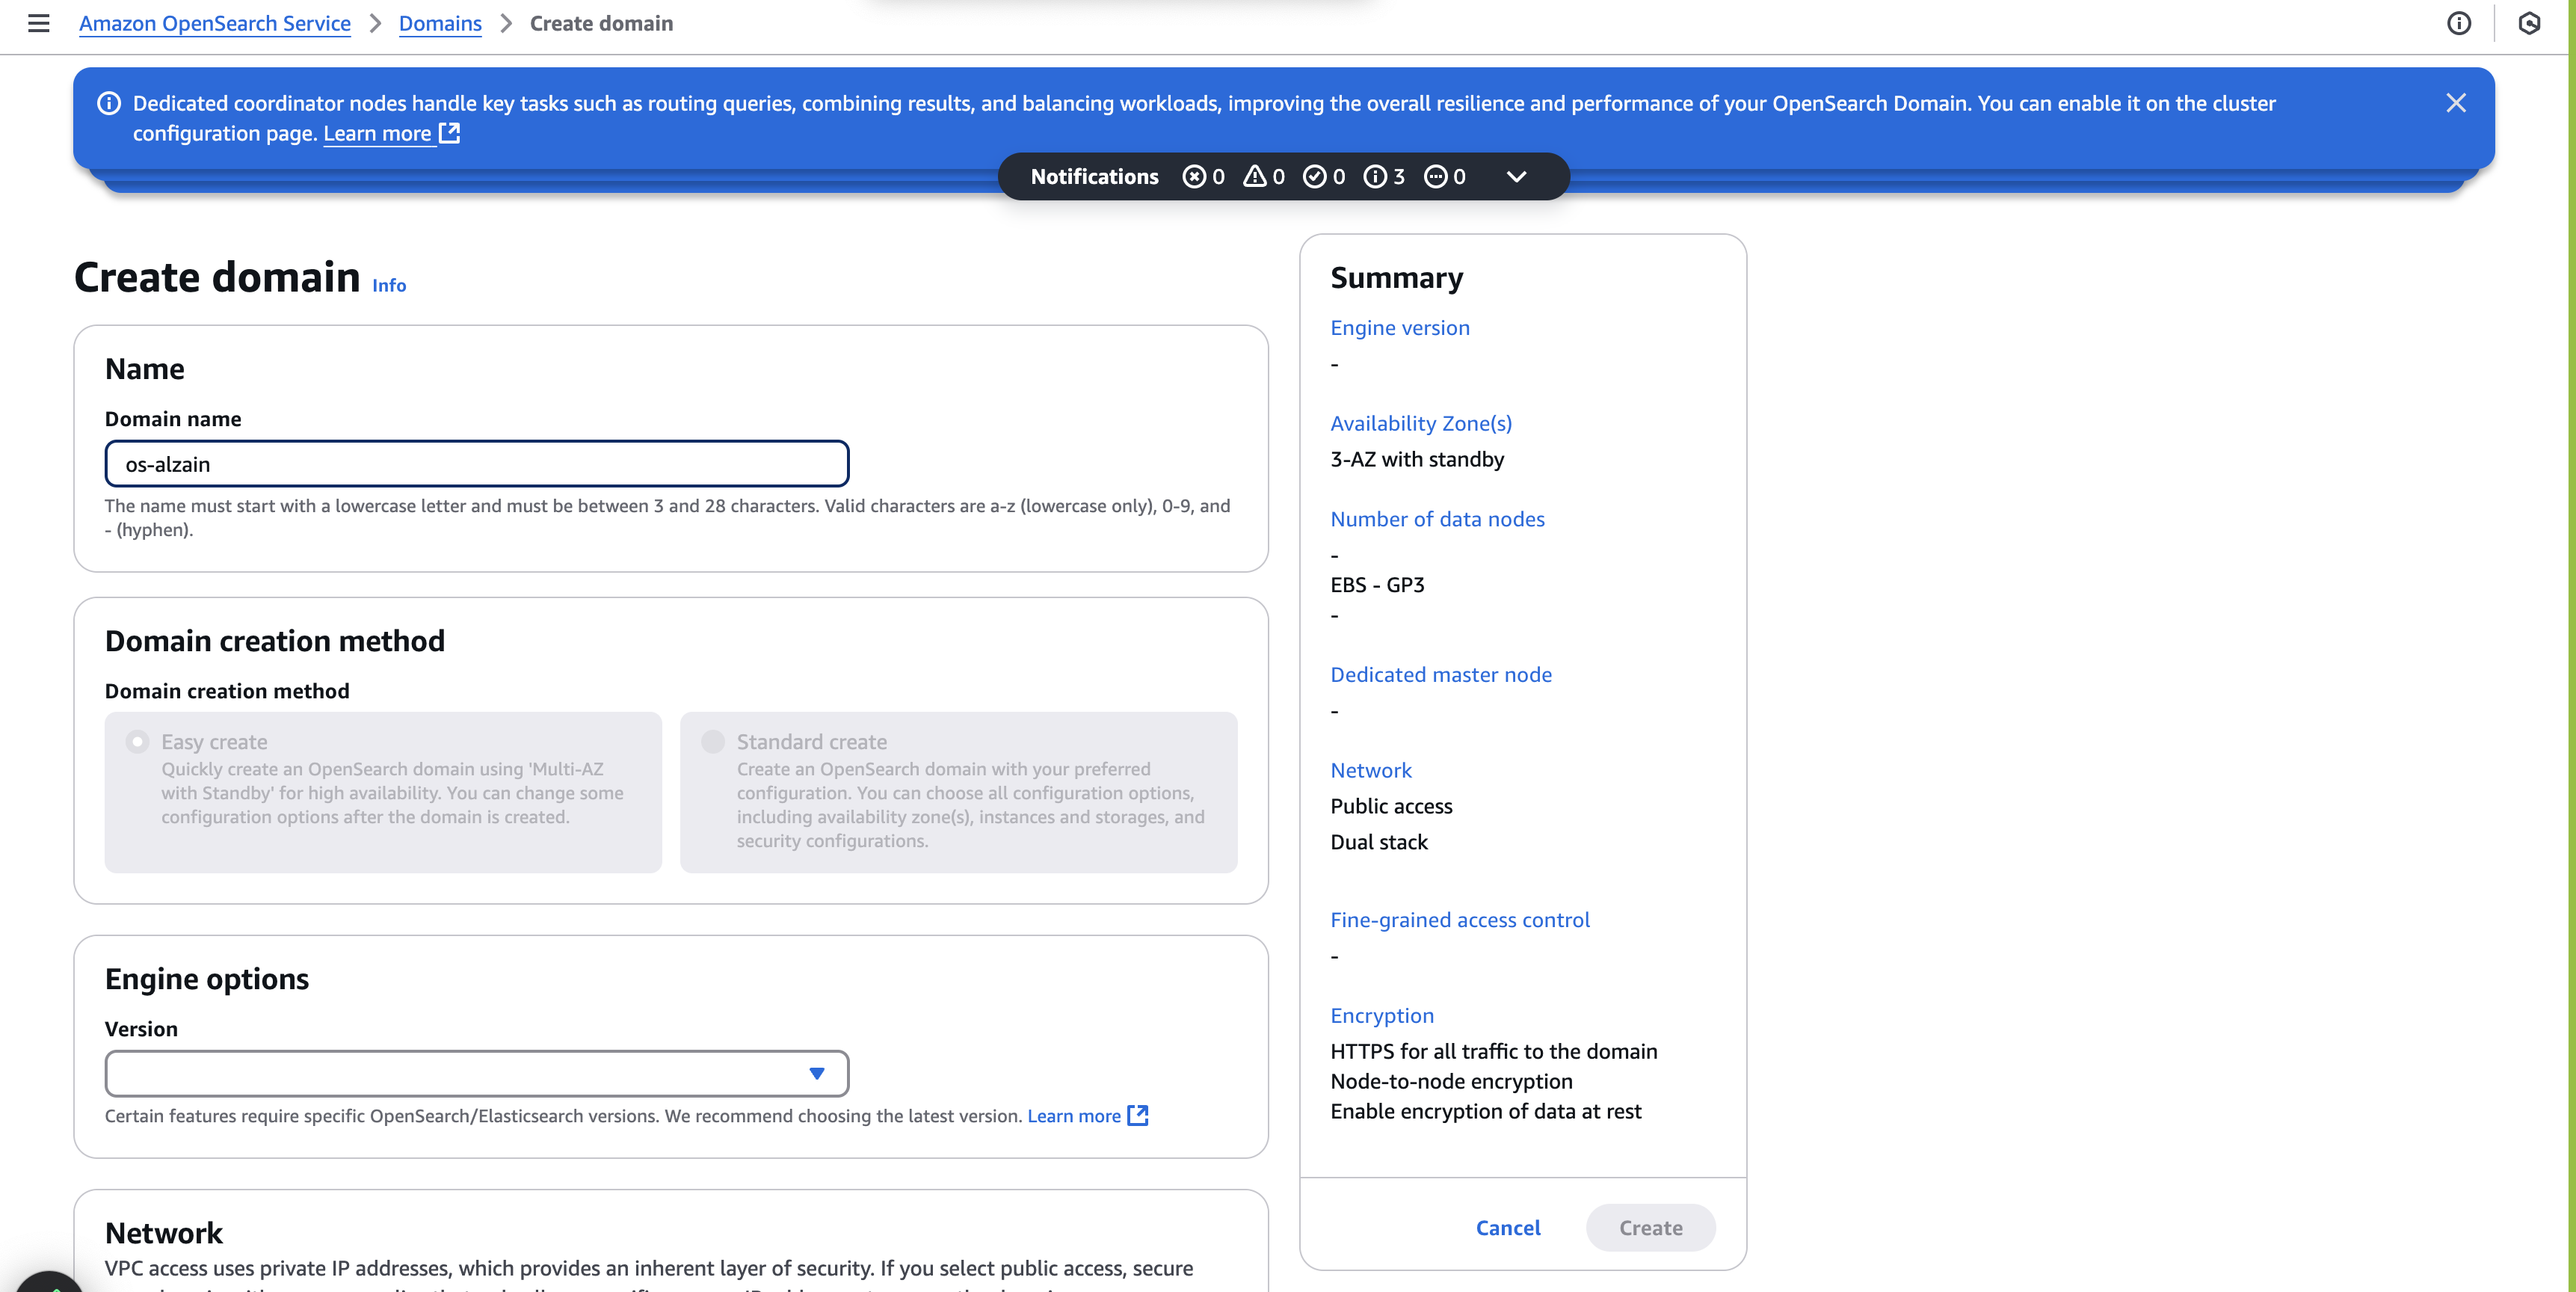

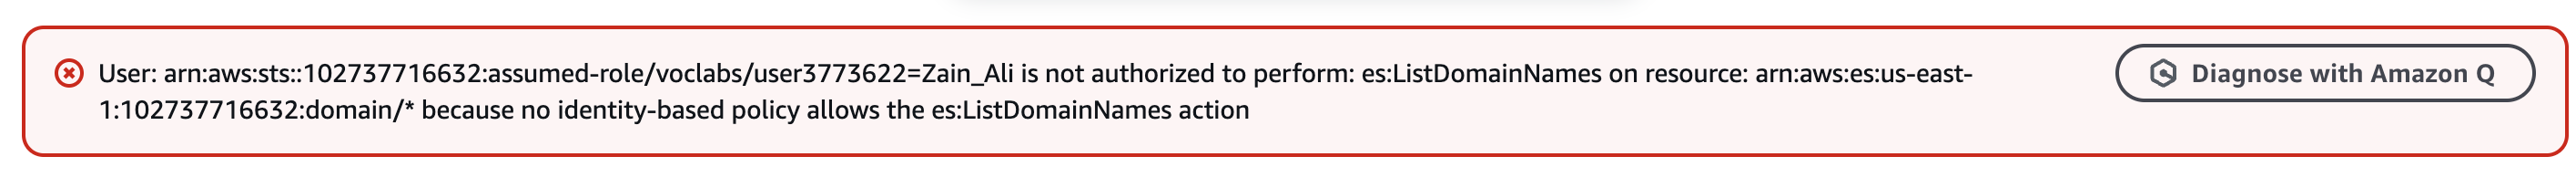

In [ ]:
display(Image(filename='supporting_media/why-pinecode-1.png'))
display(Image(filename='supporting_media/why-pinecode-2.png'))



So, we decided to go with Pinecone, as that can also be hosted through AWS.

### Pushing Chunks to Pinecone

In [ ]:
pc = pinecone.Pinecone(api_key=os.getenv("PINECONE_API_KEY"))
index_name = "tax-rag"

existing_indexes = [index.name for index in pc.list_indexes()]
if index_name not in existing_indexes:
    print(f"Creating new Pinecone index: {index_name}")
    pc.create_index(
        name=index_name,
        spec=pinecone.ServerlessSpec(
            cloud="aws",
            region="us-east-1"
        ),
        dimension=384,
        metric="cosine"
    )

index = pc.Index(index_name)
print(f"✅ Connected to Pinecone index: {index_name}")

Creating new Pinecone index: tax-rag
✅ Connected to Pinecone index: tax-rag


In [10]:
embedding_model = SentenceTransformer("all-MiniLM-L6-v2")

In [ ]:
chunk_embeddings = [
    {
        "file_name": chunk["file_name"],
        "chunk_id": chunk["chunk_id"],
        "content": chunk["content"],
        "embedding": embedding_model.encode(chunk["content"]).tolist()
    }
    for chunk in chunks
]

def batch_upsert(index, vectors, batch_size=100):
    """Uploads embeddings in batches to avoid Pinecone's request size limit."""
    for i in range(0, len(vectors), batch_size):
        batch = vectors[i : i + batch_size] 
        index.upsert(batch)
        print(f"✅ Uploaded batch {i // batch_size + 1}/{(len(vectors) // batch_size) + 1}")

vectors = [
    (f"{chunk['file_name']}_{chunk['chunk_id']}", chunk["embedding"], {"text": chunk["content"]})
    for chunk in chunk_embeddings
]

batch_upsert(index, vectors)
print("✅ All embeddings successfully stored in Pinecone!")

The cell executed successfully, but we accidentally deleted the output during the cleanup process. The complete successful run took two hours.

### Testing Embedding

In [20]:
def query_and_get_top_two(query, embedding_model, index):
    query_embedding = embedding_model.encode(query).tolist()
    results = index.query(vector=query_embedding, top_k=2, include_metadata=True)
    matches = results.get("matches", [])
    if len(matches) == 0:
        return ("", None, "", None)
    elif len(matches) == 1:
        return (matches[0]['metadata']['text'], matches[0]['score'], "", None)
    else:
        return (matches[0]['metadata']['text'], matches[0]['score'], 
                matches[1]['metadata']['text'], matches[1]['score'])

In [26]:
context1, score1, context2, score2 = query_and_get_top_two("Which forms do I need for self-employment?", embedding_model, index)


print("Top 1 Result:")
print("Text :", context1)
print("Score:", score1)

if context2:
    print("\nTop 2 Result:")
    print("Text :", context2)
    print("Score:", score2)


Top 1 Result:
Text : self-employment income from separate nonfarm or farm
businesses, each of you must complete and file a
separate Schedule C (Form 1040) or Schedule F (Form
1040). Be sure to enter at the top of each Schedule C
(Form 1040) or Schedule F (Form 1040) the name and
SSN of the spouse who owns the business. Each of you
must also complete a separate Schedule SE (Form 1040).
Attach these pages to a single Form 1040-SS.
Business Owned and Operated by
Spouses
Score: 0.604735672

Top 2 Result:
Text : Schedule SE (Form 1040), Self-Employment Tax, to complete your return.
You may only need to file Form 1040-SS and none of the schedules. However, if your return is more complicated (for
example, you claim certain deductions or credits or owe additional taxes), you will need to complete one or more of the
schedules. Below is a general guide to which schedule(s) you will need to file based on your circumstances. See the
Score: 0.598732054


### Updating the Fine-tunning Data

In [27]:
q_and_a[['Context1', 'Score1', 'Context2', 'Score2']] = q_and_a['Question'].apply(
    lambda q: pd.Series(query_and_get_top_two(q, embedding_model, index))
)

In [ ]:
q_and_a.to_csv

,Source,ID,Question,Answer,Context1,Score1,Context2,Score2
0,ChatGPT GPT4o,1,How can I reduce my tax bill?,"To lower your tax liability, consider maximizi...","System at IRS.gov/SAMS.\nFor more information,...",0.566803,WV 26106-2188. Or you can enclose\nthe check w...,0.563434
1,ChatGPT GPT4o,2,What deductions am I eligible for?,Eligibility for deductions varies based on ind...,Standard Deduction (Group I Only)\nIf you do n...,0.668105,33\nStandard Deduction Worksheet for Dependent...,0.662116
2,ChatGPT GPT4o,3,What's the difference between marginal and eff...,The marginal tax rate is the rate applied to y...,"a rate for branch profits, the rate of tax is ...",0.553689,Taxable amount over\nColumn B\nTaxable amount ...,0.487213
3,ChatGPT GPT4o,4,Which is better: a tax credit or a tax deduction?,A tax credit directly reduces your tax liabili...,"deduction, or both. However, a practice that d...",0.579091,tax deduction recognized for U.S. taxable inco...,0.547606
4,ChatGPT GPT4o,5,Can I deduct medical expenses?,"Yes, you can deduct unreimbursed medical expen...","If you itemize, you can deduct a part of your ...",0.688144,Don't include on Schedule A items deducted els...,0.681987


`Breakpoint`

Run following cells to either save or load data at this point.


In [ ]:
q_and_a_path = os.path.join(DATA_DIR, "tax-questions-answers-with-context.csv")

In [32]:
q_and_a.to_csv(q_and_a_path, index=False)

In [4]:
q_and_a = pd.read_csv(q_and_a_path)

## Model Finetunning

Our initial discovery was to find a model that was close to our needs, so an extensive finetunning will not be required. 

We found two main candidates:

- Lawma 
- saul_7b_instruct


Lawma had a 8b and also 70b.  TODO:


After unable to run these to best of our capabiities, we decided to find alternative, this is also when deepseek just recently came out. We started tested with multiple different iterations of deep seek. We found the best one to be "DeepSeek-V2-Lite", which was light and instructut and worked very well with our capabilities. 


We got a server with two a100s.


the problems of other models were not solved by even fine tunning, and overall pipeline would not work very well. 


So we decided to with deepseek fine tunning using the data I had


In [ ]:
# Set CUDA device environment variables BEFORE importing any CUDA libraries.
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"

torch.cuda.set_device(0)
print("Using GPU:", torch.cuda.current_device())


Using GPU: 0


In [ ]:
try:
    q_and_a
except NameError:
    q_and_a = pd.read_csv(q_and_a_path)

def construct_prompt(row):
    return f"""You are a helpful tax advisor and legal expert. Use the provided context to answer the user's query in a clear and concise manner.

User Query: {row['Question']}

Related Context:
{row['Context1']}
{row['Context2']}

Note: The above information is extracted from relevant forms or online sources. Use it to formulate your response."""
    
q_and_a["prompt"] = q_and_a.apply(construct_prompt, axis=1)
q_and_a["target"] = q_and_a["Answer"]

print("Data prepared: prompt and target columns added.")

from datasets import Dataset

dataset = Dataset.from_pandas(q_and_a)
dataset = dataset.train_test_split(test_size=0.2, seed=42)
train_dataset = dataset["train"]
eval_dataset = dataset["test"]

print("Train and evaluation datasets created.")


Data prepared: prompt and target columns added.
Train and evaluation datasets created.


In [ ]:
base_model_path = "./model_directory/models--deepseek-ai--DeepSeek-V2-Lite-Chat/snapshots/85864749cd611b4353ce1decdb286193298f64c7"
output_dir = "./model_directory/models--zainnobody--TaxSense/"
os.makedirs(output_dir, exist_ok=True)

# Load the tokenizer from the base model.
tokenizer = AutoTokenizer.from_pretrained(
    base_model_path,
    add_eos_token=True,
    use_fast=True,
    trust_remote_code=True,
)
tokenizer.pad_token = tokenizer.eos_token
tokenizer.pad_token_id = tokenizer.eos_token_id
tokenizer.padding_side = "left"

# Set compute dtype and attention implementation.
if torch.cuda.is_bf16_supported():
    compute_dtype = torch.bfloat16
    attn_implementation = "flash_attention_2"
else:
    compute_dtype = torch.float16
    attn_implementation = "sdpa"

# Configure 4-bit quantization settings.
bnb_config = BitsAndBytesConfig(
    load_in_4bit=True,
    bnb_4bit_quant_type="nf4",
    bnb_4bit_compute_dtype=compute_dtype,
    bnb_4bit_use_double_quant=True,
)

# Load the base model using a device map that forces it onto the current CUDA device.
model = AutoModelForCausalLM.from_pretrained(
    base_model_path,
    quantization_config=bnb_config,
    device_map={"": torch.cuda.current_device()},
    trust_remote_code=True,
)
print("Base model loaded.")

# Prepare the model for k-bit training (QLoRA).
model = prepare_model_for_kbit_training(model)

# Optionally disable gradient checkpointing if it's causing issues.
if hasattr(model, "gradient_checkpointing_disable"):
    model.gradient_checkpointing_disable()
    print("Gradient checkpointing disabled.")

# Ensure the model is on GPU 0.
model = model.to("cuda:0")
print("Model is on GPU 0.")

# Configure LoRA.
peft_config = LoraConfig(
    lora_alpha=16,
    lora_dropout=0.05,
    r=16,
    bias="none",
    task_type="CAUSAL_LM",
    target_modules="all-linear",
)


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Base model loaded.
Gradient checkpointing disabled.
Model is on GPU 0.


In [ ]:
q_and_a["token_count"] = q_and_a["prompt"].apply(lambda x: len(tokenizer.encode(x)))
max_token_len = q_and_a["token_count"].max()
if max_token_len > 512:
    num_exceeding = (q_and_a["token_count"] > 512).sum()
    print(f"Due to CUDA memory limits, we can only go up to 512 tokens. We will truncate {num_exceeding} samples.")
    max_token_len = 512



Due to CUDA memory limits, we can only go up to 512 tokens. We will truncate 4 samples.


In [13]:
def tokenize_function(examples):
    full_texts = [
        f"{prompt.strip()}\n\nResponse: {target.strip()}"
        for prompt, target in zip(examples["prompt"], examples["target"])
    ]
    return tokenizer(full_texts, truncation=True, max_length=max_token_len, padding="max_length")


In [ ]:
training_arguments = TrainingArguments(
    output_dir=output_dir,
    evaluation_strategy="steps",
    do_eval=True,
    optim="paged_adamw_8bit",
    per_device_train_batch_size=4,
    gradient_accumulation_steps=4,
    per_device_eval_batch_size=4,
    log_level="debug",
    save_strategy="epoch",
    logging_steps=100,
    learning_rate=1e-4,
    fp16=True,
    bf16=False,
    eval_steps=100,
    num_train_epochs=1,
    warmup_ratio=0.1,
    lr_scheduler_type="linear",
    local_rank=-1,
)

trainer = SFTTrainer(
    model=model,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    peft_config=peft_config,
    tokenizer=tokenizer,
    args=training_arguments,
)


comet_ml is installed but the Comet API Key is not configured. Please set the `COMET_API_KEY` environment variable to enable Comet logging. Check out the documentation for other ways of configuring it: https://www.comet.com/docs/v2/guides/experiment-management/configure-sdk/#set-the-api-key
comet_ml is installed but the Comet API Key is not configured. Please set the `COMET_API_KEY` environment variable to enable Comet logging. Check out the documentation for other ways of configuring it: https://www.comet.com/docs/v2/guides/experiment-management/configure-sdk/#set-the-api-key


Converting train dataset to ChatML:   0%|          | 0/96 [00:00<?, ? examples/s]

Applying chat template to train dataset:   0%|          | 0/96 [00:00<?, ? examples/s]

Truncating train dataset:   0%|          | 0/96 [00:00<?, ? examples/s]

Converting eval dataset to ChatML:   0%|          | 0/24 [00:00<?, ? examples/s]

Applying chat template to eval dataset:   0%|          | 0/24 [00:00<?, ? examples/s]

Truncating eval dataset:   0%|          | 0/24 [00:00<?, ? examples/s]

Using auto half precision backend
No label_names provided for model class `PeftModelForCausalLM`. Since `PeftModel` hides base models input arguments, if label_names is not given, label_names can't be set automatically within `Trainer`. Note that empty label_names list will be used instead.


In [ ]:

trainer.train()
model.save_pretrained(output_dir, safe_serialization=True)
print(f"TaxSense model saved to: {output_dir}")


Currently training with a batch size of: 4
The following columns in the training set don't have a corresponding argument in `PeftModelForCausalLM.forward` and have been ignored: prompt, Context2, Context1, ID, Score1, target, Answer, Source, Question, Score2. If prompt, Context2, Context1, ID, Score1, target, Answer, Source, Question, Score2 are not expected by `PeftModelForCausalLM.forward`,  you can safely ignore this message.
***** Running training *****
  Num examples = 96
  Num Epochs = 1
  Instantaneous batch size per device = 4
  Total train batch size (w. parallel, distributed & accumulation) = 16
  Gradient Accumulation steps = 4
  Total optimization steps = 6
  Number of trainable parameters = 289,837,056


Step,Training Loss,Validation Loss


Saving model checkpoint to ./model_directory/models--zainnobody--TaxSense/checkpoint-6
loading configuration file ./model_directory/models--deepseek-ai--DeepSeek-V2-Lite-Chat/snapshots/85864749cd611b4353ce1decdb286193298f64c7/config.json
Model config DeepseekV2Config {
  "architectures": [
    "DeepseekV2ForCausalLM"
  ],
  "attention_bias": false,
  "attention_dropout": 0.0,
  "auto_map": {
    "AutoConfig": "configuration_deepseek.DeepseekV2Config",
    "AutoModel": "modeling_deepseek.DeepseekV2Model",
    "AutoModelForCausalLM": "modeling_deepseek.DeepseekV2ForCausalLM"
  },
  "aux_loss_alpha": 0.001,
  "bos_token_id": 100000,
  "eos_token_id": 100001,
  "ep_size": 1,
  "first_k_dense_replace": 1,
  "hidden_act": "silu",
  "hidden_size": 2048,
  "initializer_range": 0.02,
  "intermediate_size": 10944,
  "kv_lora_rank": 512,
  "max_position_embeddings": 163840,
  "model_type": "deepseek_v2",
  "moe_intermediate_size": 1408,
  "moe_layer_freq": 1,
  "n_group": 1,
  "n_routed_experts":

TaxSense model saved to: ./model_directory/models--zainnobody--TaxSense/


The following code ensures that all tokenizer-related files are copied to the new model directory. 
Having the tokenizer files in one place is essential for consistency when loading the model 
for inference, ensuring the correct tokenizer configuration is used.

In [ ]:
model_files = [
    "config.json",
    "special_tokens_map.json",
    "tokenizer.json",
    "tokenizer_config.json",
    "pytorch_model.bin",
    "adapter_config.json",
    "adapter_model.bin",
]

for file_name in model_files:
    src_path = os.path.join(base_model_path, file_name)
    dest_path = os.path.join(output_dir, file_name)
    
    if os.path.isfile(src_path):
        shutil.copy(src_path, dest_path)
        print(f"Copied: {file_name} -> {output_dir}")
    else:
        print(f"Skipped: {file_name} (File not found)")

print("Model file transfer completed.")

Copied: config.json -> ./model_directory/models--zainnobody--TaxSense/
Skipped: special_tokens_map.json (File not found)
Copied: tokenizer.json -> ./model_directory/models--zainnobody--TaxSense/
Copied: tokenizer_config.json -> ./model_directory/models--zainnobody--TaxSense/
Skipped: pytorch_model.bin (File not found)
Skipped: adapter_config.json (File not found)
Skipped: adapter_model.bin (File not found)
Model file transfer completed.


In [ ]:
def human_readable_size(size, decimal_places=1):
    for unit in ['B', 'KB', 'MB', 'GB', 'TB']:
        if size < 1024.0:
            return f"{size:.{decimal_places}f} {unit}"
        size /= 1024.0
    return f"{size:.{decimal_places}f} TB"

directory = Path(base_model_path)
if directory.exists() and directory.is_dir():
    for file in directory.iterdir():
        size = human_readable_size(file.stat().st_size)
        print(f"{size} {file.name}")
else:
    print("Directory not found")

5.2 GB model-00004-of-000004.safetensors
1.2 KB tokenizer_config.json
10.1 KB configuration_deepseek.py
468.7 KB model.safetensors.index.json
1.5 KB config.json
8.0 GB model-00002-of-000004.safetensors
181.0 B generation_config.json
8.0 GB model-00001-of-000004.safetensors
4.4 MB tokenizer.json
76.8 KB modeling_deepseek.py
8.0 GB model-00003-of-000004.safetensors


In [ ]:

def load_model_and_tokenizer(model_path, device="cuda:0"):
    model = AutoModelForCausalLM.from_pretrained(model_path, trust_remote_code=True).to(device)
    tokenizer = AutoTokenizer.from_pretrained(model_path, trust_remote_code=True)
    tokenizer.pad_token = tokenizer.eos_token
    tokenizer.padding_side = "left"
    return model, tokenizer


In [ ]:
model, tokenizer = load_model_and_tokenizer(output_dir)

Ran into following issue:

```
OSError: ./model_directory/models--zainnobody--TaxSense/ does not appear to have a file named modeling_deepseek.py. Checkout 'https://huggingface.co/./model_directory/models--zainnobody--TaxSense//tree/None' for available files.
```

Resolving this:

In [ ]:

def human_readable_size(size, decimal_places=1):
    for unit in ['B', 'KB', 'MB', 'GB', 'TB']:
        if size < 1024.0:
            return f"{size:.{decimal_places}f} {unit}"
        size /= 1024.0
    return f"{size:.{decimal_places}f} TB"

directory = Path(base_model_path)
if directory.exists() and directory.is_dir():
    for file in directory.iterdir():
        size = human_readable_size(file.stat().st_size)
        print(f"{size} {file.name}")
else:
    print("Directory not found")


5.2 GB model-00004-of-000004.safetensors
1.2 KB tokenizer_config.json
10.1 KB configuration_deepseek.py
468.7 KB model.safetensors.index.json
1.5 KB config.json
8.0 GB model-00002-of-000004.safetensors
181.0 B generation_config.json
8.0 GB model-00001-of-000004.safetensors
4.4 MB tokenizer.json
76.8 KB modeling_deepseek.py
8.0 GB model-00003-of-000004.safetensors


In [10]:
deepseek_model_file = "modeling_deepseek.py"
src_path = os.path.join(base_model_path, deepseek_model_file)
dest_path = os.path.join(output_dir, deepseek_model_file)

if os.path.exists(src_path):
    shutil.copy2(src_path, dest_path)  # copy2 preserves metadata
    print(f"Copied {deepseek_model_file} to {output_dir}")
else:
    print(f"File {deepseek_model_file} not found in {base_model_path}, check if it exists.")

Copied modeling_deepseek.py to ./model_directory/models--zainnobody--TaxSense/


In [ ]:
model, tokenizer = load_model_and_tokenizer(output_dir)

print("Model loaded.")

I cleaned the last cell, as the output was huge.

The logs show that while loading the checkpoint shards, several weights weren't used during model initialization:

```
Loading checkpoint shards: 100%
 3/3 [00:47<00:00, 13.32s/it]
Some weights of the model checkpoint at ./model_directory/models--zainnobody--TaxSense/ were not used when initializing DeepseekV2ForCausalLM: {'model.layers.9.mlp.experts.60.up_proj.lora_A.default.weight', 'model.layers.13.mlp.experts.7.down_proj.lora_B.default.weight', 'model.layers.22.mlp.experts.44.up_proj.base_layer.weight.quant_map', 'model.layers.1.mlp.experts.48.gate_proj.base_layer.weight.quant_map',...
```

This happens because when fine-tuning with LoRA (using PEFT), additional parameters like `lora_A.default.weight` and `lora_B.default.weight` are injected into the model. However, using a standard call like `AutoModelForCausalLM.from_pretrained(finetuned_dir)` does not automatically load these extra LoRA weights, which results in the warning about unused or missing parameters.

In [ ]:

lora_output_dir = os.path.join(output_dir, "checkpoint-6")

max_memory = {
    0: "20GiB",
    1: "20GiB",
}

base_model = AutoModelForCausalLM.from_pretrained(
    base_model_path,
    trust_remote_code=True,
    device_map="auto",
    max_memory=max_memory,
    torch_dtype=torch.float16,
)

model = PeftModel.from_pretrained(
    base_model,
    lora_output_dir,
    device_map="auto",
    max_memory=max_memory,
    torch_dtype=torch.float16,
)

tokenizer = AutoTokenizer.from_pretrained(
    base_model_path,
    trust_remote_code=True
)

tokenizer.pad_token = tokenizer.eos_token
tokenizer.padding_side = "left"

print("Successfully loaded the model + LoRA adapter across multiple GPUs.")

2025-03-01 21:24:42.809166: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-03-01 21:24:43.693999: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

Successfully loaded the model + LoRA adapter across multiple GPUs.


Just manual checking: 

In [ ]:
def construct_prompt(question, context1, context2):
    return f"""You are a helpful tax advisor and legal expert. Use the provided context to answer the user's query in a clear and concise manner.

User Query: {question}

Related Context:
{context1}
{context2}

Note: The above information is extracted from relevant forms or online sources. Use it to formulate your response.

Response:
"""

def generate_reply(prompt, max_new_tokens=256):
    gen_config = GenerationConfig(
        max_new_tokens=max_new_tokens,
        temperature=0.7,
        top_p=0.9,
        do_sample=True
    )
    inputs = tokenizer(prompt, return_tensors="pt").to(model.device)

    with torch.no_grad(), torch.cuda.amp.autocast(enabled=True):
        output_tokens = model.generate(
            **inputs,
            generation_config=gen_config,
            use_cache=False
        )

    return tokenizer.decode(
        output_tokens[0][inputs["input_ids"].shape[1]:],
        skip_special_tokens=True
    )

indices_to_test = [0, 1, 2]

for idx in indices_to_test:
    question = df.loc[idx, "Question"]
    expected_answer = df.loc[idx, "Answer"]
    context1 = df.loc[idx, "Context1"]
    context2 = df.loc[idx, "Context2"]
    
    test_prompt = construct_prompt(question, context1, context2)
    model_reply = generate_reply(test_prompt)

    print("=" * 60)
    print(f"Sample Index: {idx}")
    print("-" * 60)
    print("QUESTION:")
    print(question)
    print("\nCONTEXT USED:")
    print("Context1:", context1)
    print("Context2:", context2)
    print("\nEXPECTED REPLY:")
    print(expected_answer)
    print("\nMODEL REPLY:")
    print(model_reply)
    print("=" * 60, "\n")


/tmp/ipykernel_262501/3772536405.py:48: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.no_grad(), torch.cuda.amp.autocast(enabled=True):
Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


Sample Index: 0
------------------------------------------------------------
QUESTION:
How can I reduce my tax bill?

CONTEXT USED:
Context1: System at IRS.gov/SAMS.
For more information, go to IRS.gov/Advocate.
How To Make a Contribution To
Reduce Debt Held by the Public
There are two ways to make a contribution to reduce the
debt held by the public.
• At Pay.gov, contribute online by credit card, debit card,
PayPal, checking account, or savings account.
• Write a check payable to “Bureau of the Fiscal Service.”
In the memo section, notate that it is a gift to reduce the
debt held by the public.
Mail the check to:
Attn: Dept G
Context2: WV 26106-2188. Or you can enclose
the check with your income tax return
when you file. In the memo section of
the check, make a note that it is a gift to
reduce the debt held by the public. Don’t
add your gift to any tax you may owe.
See the instructions for line 37 for de-
tails on how to pay any tax you owe. For
information on how to make this type o

Setting `pad_token_id` to `eos_token_id`:100001 for open-end generation.


Sample Index: 1
------------------------------------------------------------
QUESTION:
What deductions am I eligible for?

CONTEXT USED:
Context1: Standard Deduction (Group I Only)
If you do not itemize your deductions, you can take the 2025
standard deduction listed below for your filing status.
Filing Status
Standard
Deduction
Married filing jointly or
Qualifying surviving spouse
. . . . . . . . . . . . . .
$30,000\*
Head of household . . . . . . . . . . . . . . . . . . . .
$22,500\*
Single or Married filing
separately
. . . . . . . . . . . . . . . . . . . . . . . . .
$15,000\*
Context2: 33
Standard Deduction Worksheet for Dependents—Line 12
Keep for Your Records
Use this worksheet only if someone can claim you, or your spouse if filing jointly, as a dependent.
1.
Check if:
You were born before January 2, 1960.
You are blind.
Spouse was born before January 2, 1960.
Spouse is blind.
Total number of boxes
checked
. . . . . . . . . . . . . . . . . .
1.
2.
Is your earned income\* more th

**Challenges Encountered:**

1. **Time Efficiency:** The fine-tuned model significantly increases processing time, taking 15 minutes to handle just 3 queries, whereas other models complete this task within seconds.
   
2. **Resource Intensive:** The model demands higher GPU resources for inference, which may not be feasible for all setups.

3. **Data Requirements:** Effective fine-tuning requires a substantial volume of high-quality data, which implies extended periods for data collection.

4. **Model Complexity:** Our contributions added 289,837,056 trainable parameters to the model. However, DeepSeek V2 Lite already operates with 16 billion total parameters and 2.4 billion active ones, offering high efficiency and speed that might not be fully leveraged by our additions.

Efforts to reduce the `max_new_tokens` parameter to 128 yielded a marginal improvement in response time to 3 minutes and 52 seconds, albeit with shorter output responses.


The primary focus of this project is on enhancing the ML Ops aspects of AI, emphasizing efficient execution and processing of user responses rather than optimizing a single model. With that in mind, we will include the "TaxSense" model as one of the options available to users. Also, the model will be available for further testing on hugging face. 

### Hugging Face upload

In [ ]:

api = HfApi()
create_repo(repo_id="zainnobody/TaxSense", private=False, exist_ok=True)
upload_folder(
    repo_id="zainnobody/TaxSense",
    folder_path="./model_directory/models--zainnobody--TaxSense/",
    path_in_repo=".",
    commit_message="Initial commit"
)

rng_state.pth:   0%|          | 0.00/14.2k [00:00<?, ?B/s]

optimizer.pt:   0%|          | 0.00/601M [00:00<?, ?B/s]

scaler.pt:   0%|          | 0.00/988 [00:00<?, ?B/s]

adapter_model.safetensors:   0%|          | 0.00/1.16G [00:00<?, ?B/s]

Upload 20 LFS files:   0%|          | 0/20 [00:00<?, ?it/s]

scheduler.pt:   0%|          | 0.00/1.06k [00:00<?, ?B/s]

training_args.bin:   0%|          | 0.00/5.62k [00:00<?, ?B/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/4.91G [00:00<?, ?B/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/839M [00:00<?, ?B/s]

events.out.tfevents.1740856547.b3c7d853-4c5a-4a0a-ab54-087dc02516fb.176706.0:   0%|          | 0.00/7.39k [00:…

events.out.tfevents.1740857662.b3c7d853-4c5a-4a0a-ab54-087dc02516fb.194220.0:   0%|          | 0.00/6.98k [00:…

events.out.tfevents.1740857841.b3c7d853-4c5a-4a0a-ab54-087dc02516fb.196038.0:   0%|          | 0.00/6.98k [00:…

events.out.tfevents.1740857960.b3c7d853-4c5a-4a0a-ab54-087dc02516fb.197340.0:   0%|          | 0.00/6.98k [00:…

events.out.tfevents.1740858035.b3c7d853-4c5a-4a0a-ab54-087dc02516fb.198196.0:   0%|          | 0.00/7.39k [00:…

events.out.tfevents.1740858797.b3c7d853-4c5a-4a0a-ab54-087dc02516fb.205802.0:   0%|          | 0.00/6.98k [00:…

events.out.tfevents.1740858884.b3c7d853-4c5a-4a0a-ab54-087dc02516fb.206757.0:   0%|          | 0.00/6.98k [00:…

events.out.tfevents.1740858974.b3c7d853-4c5a-4a0a-ab54-087dc02516fb.207760.0:   0%|          | 0.00/6.98k [00:…

events.out.tfevents.1740859189.b3c7d853-4c5a-4a0a-ab54-087dc02516fb.209938.0:   0%|          | 0.00/88.0 [00:0…

events.out.tfevents.1740859411.b3c7d853-4c5a-4a0a-ab54-087dc02516fb.212192.0:   0%|          | 0.00/6.98k [00:…

events.out.tfevents.1740859854.b3c7d853-4c5a-4a0a-ab54-087dc02516fb.216891.0:   0%|          | 0.00/7.39k [00:…

CommitInfo(commit_url='https://huggingface.co/zainnobody/TaxSense/commit/60fdc1255746c082f57b93e6615cf047e2adcd53', commit_message='Initial commit', commit_description='', oid='60fdc1255746c082f57b93e6615cf047e2adcd53', pr_url=None, repo_url=RepoUrl('https://huggingface.co/zainnobody/TaxSense', endpoint='https://huggingface.co', repo_type='model', repo_id='zainnobody/TaxSense'), pr_revision=None, pr_num=None)

## Out-of-Box Model Exploration & Chat Generation End Points

After generating our in-house model, we quickly discovered that it might not meet all our performance and domain-specific requirements. As a result, we began exploring several external candidates. Our shortlist includes:

| **Model**                              | **Architecture / Basis**                                             | **Estimated Max Token Limit** | **Estimated Max Word Limit**  |
|----------------------------------------|----------------------------------------------------------------------|-------------------------------|-------------------------------|
| ricdomolm/lawma-8b                     | Fine‑tuned on Llama‑3 8B Instruct                                    | ~8,192 tokens                 | ~6,000 words                  |
| Equall/Saul-7B-Instruct-v1             | Continued pretraining of Mistral‑7B                                  | ~8,192 tokens                 | ~6,000 words                  |
| deepseek‑ai/DeepSeek‑V2‑Lite (and Chat)  | Mixture‑of‑Experts (MoE) model with an extended context window       | 32,000 tokens                 | ~24,000 words                 |
| ricdomolm/lawma-70b                    | Fine‑tuned on Llama‑3 70B Instruct for legal classification tasks¹    | ~4,096 tokens                 | ~3,072 words                  |

¹ Although the base Llama‑3‑70B model supports an 8k-token context, this version was configured for legal classification—where shorter inputs (and corresponding outputs) are sufficient—resulting in an effective limit of approximately 4k tokens.

### Model Insights

**ricdomolm/lawma-8b**  
This model is tailored for the legal domain, fine-tuned on the Llama‑3 8B Instruct model. It is optimized for legal classification tasks, making it highly specialized for tasks like interpreting legal documents and handling legal language nuances.

**Equall/Saul-7B-Instruct-v1**  
Based on the Mistral‑7B architecture, this model has been further pre-trained to handle legal language instructions. Its training focused on generating clear and accurate legal text, making it a strong candidate for tasks such as drafting legal documents, summarizing case law, and answering legal queries.

**deepseek‑ai/DeepSeek‑V2‑Lite (and Chat)**  
DeepSeek has generated significant attention for its ease of integration and the benefits of an extended context window. We were particularly drawn to its user-friendly design and, as a result, fine-tuned this model for our internal "TaxesSense" application. Its ability to process larger text blocks is a promising feature for future applications.

**ricdomolm/lawma-70b**  
While our primary focus is on the 8B models, we have also kept the 70B variant in mind. Although configured with a shorter effective token limit for legal classification, this model remains an interesting candidate to explore if the 8B models do not meet our needs.

### Hosting Challenges and Our Backend Solution

We encountered significant challenges while attempting to host these models directly on AWS SageMaker, primarily due to permission issues. To overcome this, we decided to deploy these models as internal endpoints. This approach gives us greater control over model management and sidesteps the restrictions posed by AWS SageMaker.



### Endpoint Implementation

For our initial deployment, we created two endpoints: one for standard generation and another for streaming generation. Below is a streamlined version of the endpoint code:

```python
@app.route('/generate', methods=['POST'])
@token_required
def generate_text():
    data = request.get_json()
    model_name = data.get("model_name")
    if not model_name:
        return jsonify({"error": "model_name is required"}), 400
    if model_name not in MODEL_PATHS:
        return jsonify({"error": f"Unknown model_name: {model_name}"}), 400

    question = data.get("text", "")
    max_length = data.get("max_length")
    if max_length is None:
        return jsonify({"error": "max_length must be provided"}), 400

    prompt = build_prompt(question)
    try:
        generated_text, response_time, _ = perform_generation(model_name, prompt, max_length)
    except Exception as e:
        return jsonify({"error": str(e)}), 500

    return jsonify({
        "response": generated_text,
        "time_taken": response_time,
        "model": model_name
    })

@app.route('/generate_stream', methods=['POST'])
@token_required
def generate_text_stream():
    data = request.get_json()
    model_name = data.get("model_name")
    if not model_name:
        return jsonify({"error": "model_name is required"}), 400
    if model_name not in MODEL_PATHS:
        return jsonify({"error": f"Unknown model_name: {model_name}"}), 400

    question = data.get("text", "")
    max_length = data.get("max_length")
    if max_length is None:
        return jsonify({"error": "max_length must be provided"}), 400

    try:
        load_model(model_name)
    except Exception as e:
        return jsonify({"error": str(e)}), 500

    tokenizer = loaded_models[model_name]["tokenizer"]
    model = loaded_models[model_name]["model"]
    prompt = build_prompt(question)
    inputs = tokenizer(prompt, return_tensors="pt")
    streamer = TextIteratorStreamer(tokenizer, skip_prompt=True, skip_special_tokens=True)

    def run_generation():
        try:
            model.generate(
                **inputs,
                max_new_tokens=max_length,
                do_sample=True,
                eos_token_id=tokenizer.eos_token_id,
                pad_token_id=tokenizer.eos_token_id,
                streamer=streamer
            )
        except Exception as e:
            print(f"Error during stream generation with model {model_name}:", str(e))

    thread = threading.Thread(target=run_generation)
    thread.start()
    loaded_models[model_name]["last_access_time"] = time.time()
    return Response(streamer, mimetype="text/plain")
```



### Testing Considerations

For testing, we focused our efforts on the out-of-box models. Testing our in-house models proved time-consuming—each test taking over half an hour—so the initial extensive testing was reserved for these external candidates.

### Tests - Generate

Below we are testing the `/generate` and `/generate_stream` endpoints. The tests verify that if a model is not already loaded, it initializes correctly and handles the first request with longer latency, while subsequent requests are faster. We check full text generation as well as token-by-token streaming, ensuring both endpoints work as expected and expose any issues for further optimization.


> NOTE: When a model is already loaded, requests are processed immediately. If a model isn’t loaded, it will first be initialized before handling the request, causing the initial call to take longer. Subsequent requests are processed quickly, while larger models naturally take more time to load.

In [ ]:
BASE_URL = "http://100.118.250.126:6000" # Also worked on: "http://localhost:6000" 
GENERATE_URL = f"{BASE_URL}/generate"
GENERATE_STREAM_URL = f"{BASE_URL}/generate_stream"


In [ ]:

def generate_text(model_name, text, max_length=100):
    payload = {
        "model_name": model_name,
        "text": text,
        "max_length": max_length
    }
    
    response = requests.post(GENERATE_URL, json=payload)
    
    if response.status_code == 200:
        data = response.json()
        print("\n=== /generate ===")
        print(f"Model Name: {model_name}")
        print(f"Prompt: {text}")
        print("Generated Text:")
        print(data.get("response", "No response field in JSON"))
        print(f"Time taken: {data.get('time_taken', 'N/A')} seconds")
    else:
        print(f"Error: {response.status_code} - {response.text}")

def generate_text_stream(model_name, text, max_length=100):

    payload = {
        "model_name": model_name,
        "text": text,
        "max_length": max_length
    }
    
    response = requests.post(GENERATE_STREAM_URL, json=payload, stream=True)
    
    if response.status_code == 200:
        print("\n=== /generate_stream ===")
        print(f"Model Name: {model_name}")
        print(f"Prompt: {text}")
        print("Streaming Generated Text:")
        for chunk in response.iter_lines(decode_unicode=True):
            if chunk:
                print(chunk, end=" ", flush=True)
        print()
    else:
        print(f"Error: {response.status_code} - {response.text}")

# Example prompts
prompt1 = "Explain the key differences between tax credits and tax deductions."  
prompt2 = "What are the potential risks and benefits of automating IRS tax processing?"  


Also the code run until this was:

```
python3 app.py 
 * Serving Flask app 'app'
 * Debug mode: off
WARNING: This is a development server. Do not use it in a production deployment. Use a production WSGI server instead.
 * Running on all addresses (0.0.0.0)
 * Running on http://127.0.0.1:6000
 * Running on http://100.118.250.126:6000

```

> NOTE: The `app.py` is synonymous to `TaxSense_backend.py`.

In [13]:
# Test: Using "lawma_70b" model. This is a large model.
generate_text("lawma_70b", prompt1, max_length=100)
generate_text_stream("lawma_70b", prompt2, max_length=100)


=== /generate ===
Model Name: lawma_70b
Prompt: Explain the key differences between tax credits and tax deductions.
Generated Text:
You are a helpful tax and legal advisor. Answer the following question in a clear and concise manner:
Explain the key differences between tax credits and tax deductions. 't use legal jargon.
It seems like tax credits and tax deductions both reduce your tax bill, but I've heard they work differently.  I'd love to understand the differences.
Answer: I'd be happy to help you with that!

Tax credits and tax deductions both reduce your tax bill, but they work in different ways.

Tax DEDUCTIONS:

1. Reduce taxable income: DEDUCTIONS lower your taxable income, which means you're reducing the amount of income that's ...
Time taken: 4780.952471971512 seconds

=== /generate_stream ===
Model Name: lawma_70b
Prompt: What are the potential risks and benefits of automating IRS tax processing?
Streaming Generated Text:
  


Here are the logs for the above cell:


```
[load_model] Attempting to load 'lawma_70b' onto cuda:1 ...
2025-02-17 10:04:00.794940: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-02-17 10:04:01.810556: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Loading checkpoint shards: 100%|█████████████| 30/30 [02:31<00:00,  5.04s/it]
Some parameters are on the meta device because they were offloaded to the cpu.
[load_model] 'lawma_70b' loaded on cuda:1. Current allocated: 39168.75 MB
172.24.9.126 - - [17/Feb/2025 10:35:00] "POST /generate HTTP/1.1" 200 -
172.24.9.126 - - [17/Feb/2025 10:35:16] "POST /generate_stream HTTP/1.1" 200 

```

In [ ]:
# Running again to check if its an end point issue
generate_text_stream("lawma_70b", prompt2, max_length=100)


=== /generate_stream ===
Model Name: lawma_70b
Prompt: What are the potential risks and benefits of automating IRS tax processing?
Streaming Generated Text:
  Answer: K 


Seems like there is an issue with the stream answers with 70b. 


Also, here are the logs:


```

[load_model] Attempting to load 'lawma_70b' ...
2025-02-17 21:51:20.115131: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-02-17 21:51:21.135897: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Loading checkpoint shards: 100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 30/30 [00:50<00:00,  1.67s/it]
Some parameters are on the meta device because they were offloaded to the cpu.
[load_model] 'lawma_70b' loaded. It has been automatically partitioned across available GPUs.
/apps/default-python/lib/python3.10/site-packages/transformers/generation/utils.py:2137: UserWarning: You are calling .generate() with the `input_ids` being on a device type different than your model's device. `input_ids` is on cpu, whereas the model is on cuda. You may experience unexpected behaviors or slower generation. Please make sure that you have put `input_ids` to the correct device by calling for example input_ids = input_ids.to('cuda') before running `.generate()`.
  warnings.warn(
172.24.9.126 - - [17/Feb/2025 21:52:30] "POST /generate_stream HTTP/1.1" 200 -

```

In [12]:
# Test: Using "saul_7b_instruct" model
generate_text("saul_7b_instruct", prompt1, max_length=50)
generate_text_stream("saul_7b_instruct", prompt2, max_length=50)


=== /generate ===
Model Name: saul_7b_instruct
Prompt: Explain the key differences between tax credits and tax deductions.
Generated Text:
You are a helpful tax and legal advisor. Answer the following question in a clear and concise manner:
Explain the key differences between tax credits and tax deductions.
Answer: [/INST] Tax credits and tax deductions are two important tools used to reduce a person's taxable income. However, they work in different ways and have distinct characteristics.

A tax credit directly reduces your ...
Time taken: 2.0661349296569824 seconds

=== /generate_stream ===
Model Name: saul_7b_instruct
Prompt: What are the potential risks and benefits of automating IRS tax processing?
Streaming Generated Text:
What are potential risks and benefits of this approach to handling tax returns? [/INST] Automating IRS tax processing can provide several benefits and risks: Benefits: 1. Improved efficiency - Automation can help process 


Here are the logs for the above cell:


```

[load_model] Attempting to load 'saul_7b_instruct' ...
Loading checkpoint shards: 100%|███████████████| 6/6 [01:12<00:00, 12.11s/it]
[load_model] 'saul_7b_instruct' loaded. It has been automatically partitioned across available GPUs.
/apps/default-python/lib/python3.10/site-packages/transformers/generation/utils.py:2137: UserWarning: You are calling .generate() with the `input_ids` being on a device type different than your model's device. `input_ids` is on cpu, whereas the model is on cuda. You may experience unexpected behaviors or slower generation. Please make sure that you have put `input_ids` to the correct device by calling for example input_ids = input_ids.to('cuda') before running `.generate()`.
  warnings.warn(
172.24.9.126 - - [17/Feb/2025 10:59:03] "POST /generate HTTP/1.1" 200 -
172.24.9.126 - - [17/Feb/2025 10:59:04] "POST /generate_stream HTTP/1.1" 200 


```


In [11]:
# Test: Using "lawma_8b" model
generate_text("lawma_8b", prompt1, max_length=50)
generate_text_stream("lawma_8b", prompt2, max_length=50)



=== /generate ===
Model Name: lawma_8b
Prompt: Explain the key differences between tax credits and tax deductions.
Generated Text:
You are a helpful tax and legal advisor. Answer the following question in a clear and concise manner:
Explain the key differences between tax credits and tax deductions. A tax credit reduces 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 ...
Time taken: 2.511077404022217 seconds

=== /generate_stream ===
Model Name: lawma_8b
Prompt: What are the potential risks and benefits of automating IRS tax processing?
Streaming Generated Text:
 A B C D E F G H I J E F G H I J E F G H I J E F G H I J E F G H I J E F G H I J E F G H I J E F G H 


Here are the logs for the above cell:


```
[load_model] Attempting to load 'lawma_8b' ...
Loading checkpoint shards: 100%|███████████████| 4/4 [00:37<00:00,  9.28s/it]
[load_model] 'lawma_8b' loaded. It has been automatically partitioned across available GPUs.
/apps/default-python/lib/python3.10/site-packages/transformers/generation/utils.py:2137: UserWarning: You are calling .generate() with the `input_ids` being on a device type different than your model's device. `input_ids` is on cpu, whereas the model is on cuda. You may experience unexpected behaviors or slower generation. Please make sure that you have put `input_ids` to the correct device by calling for example input_ids = input_ids.to('cuda') before running `.generate()`.
  warnings.warn(
172.24.9.126 - - [17/Feb/2025 10:57:45] "POST /generate HTTP/1.1" 200 -
172.24.9.126 - - [17/Feb/2025 10:57:46] "POST /generate_stream HTTP/1.1" 200 

```

In [10]:
# Test: Using "DeepSeek-V2-Lite" model
generate_text("DeepSeek-V2-Lite", prompt2, max_length=200)
generate_text_stream("DeepSeek-V2-Lite", prompt1, max_length=200)


=== /generate ===
Model Name: DeepSeek-V2-Lite
Prompt: What are the potential risks and benefits of automating IRS tax processing?
Generated Text:
You are a helpful tax and legal advisor. Answer the following question in a clear and concise manner:
What are the potential risks and benefits of automating IRS tax processing?

Automating IRS tax processing can have several potential risks and benefits. Here are some of them:

Risks:
1. Data Security: Automated systems can be vulnerable to cyber-attacks, leading to unauthorized access to sensitive taxpayer information.
2. System Errors: Automation can lead to errors in processing, such as incorrect calculations or misinterpretation of tax codes.
3. Dependence on Technology: Over-reliance on automated systems can make the IRS vulnerable to technical failures or outages.
4. Training and Support: Staff may require additional training to effectively use new automated systems, which can be costly and time-consuming.

Benefits:
1. Efficiency: A

Here are the logs for the above cell:


```

[load_model] Attempting to load 'DeepSeek-V2-Lite' ...
2025-02-17 10:53:39.516528: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-02-17 10:53:40.689715: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
Loading checkpoint shards: 100%|███████████████| 4/4 [00:22<00:00,  5.56s/it]
[load_model] 'DeepSeek-V2-Lite' loaded. It has been automatically partitioned across available GPUs.
/apps/default-python/lib/python3.10/site-packages/transformers/generation/utils.py:2137: UserWarning: You are calling .generate() with the `input_ids` being on a device type different than your model's device. `input_ids` is on cpu, whereas the model is on cuda. You may experience unexpected behaviors or slower generation. Please make sure that you have put `input_ids` to the correct device by calling for example input_ids = input_ids.to('cuda') before running `.generate()`.
  warnings.warn(
The `seen_tokens` attribute is deprecated and will be removed in v4.41. Use the `cache_position` model input instead.
`get_max_cache()` is deprecated for all Cache classes. Use `get_max_cache_shape()` instead. Calling `get_max_cache()` will raise error from v4.48
172.24.9.126 - - [17/Feb/2025 10:54:36] "POST /generate HTTP/1.1" 200 -
172.24.9.126 - - [17/Feb/2025 10:54:37] "POST /generate_stream HTTP/1.1" 200

```

#### Summary Analysis

DeepSeek-V2-Lite is the fastest and offers the most detailed and clear responses compared to the other models. Saul_7b_instruct provides good, concise answers, but it doesn't go into as much depth. Lawma_70b, on the other hand, takes far too long to respond and often struggles to complete tasks, sometimes needing help from other models. Lawma_8b is quicker than Lawma_70b, but its output can be inconsistent and sometimes messy. Overall, DeepSeek-V2-Lite strikes the best balance between speed, quality, and reliability.

### Standardizing End Points

We added new endpoints (`/v1/models`, `/v1/chat/completions`, and `/v1/completions`) that leverage this helper to ensure consistent responses and reduced code duplication. This was to align us with the testing we were doing using LM Studio, and the endpoints seem to be the standard. Following is the test for each of the end point. These endpoints updates a bit later with authentication code, user info, and chat session info.

In [22]:
MODELS_URL = f"{BASE_URL}/v1/models"
CHAT_COMPLETIONS_URL = f"{BASE_URL}/v1/chat/completions"
COMPLETIONS_URL = f"{BASE_URL}/v1/completions"

#### `/v1/models`

##### Code 

Here is the code implimented the `TaxSense_backend.py` for this models end point:


```python
@app.route('/v1/models', methods=['GET'])
@token_required
def list_models():
    models = [{"id": name, "object": "model"} for name in MODEL_PATHS.keys()]
    return jsonify({"data": models, "object": "list"})

```


The models are defined using two dictionaries:

- **MODEL_PATHS**: Maps model names to their corresponding file system paths.
- **MODEL_CONFIGS**: Provides additional configuration details such as the Hugging Face identifier (`hf_id`) and whether to use parameter-efficient fine-tuning (`use_peft`).

Can be seen here:


```python

MODEL_PATHS = {
    "saul_7b_instruct": "./model_directory/models--Equall--Saul-7B-Instruct-v1/snapshots/2133ba7923533934e78f73848045299dd74f08d2",
    "lawma_8b": "./model_directory/models--ricdomolm--lawma-8B/snapshots/cf7b9086448228ba981a9748012a97b616a70579",
    "lawma_70b": "./model_directory/models--ricdomolm--lawma-70b/snapshots/cf7b9086448228ba981a9748012a97b616a70579",
    "DeepSeek-V2-Lite": "./model_directory/models--deepseek-ai--DeepSeek-V2-Lite-Chat/snapshots/85864749cd611b4353ce1decdb286193298f64c7",
    "TaxSense": "./model_directory/models--zainnobody--TaxSense"
}

MODEL_CONFIGS = {
    "TaxSense": {
        "hf_id": "zainnobody/TaxSense",
        "use_peft": True
    },
    "saul_7b_instruct": {
        "hf_id": "Equall/Saul-7B-Instruct-v1"
    },
    "lawma_8b": {
        "hf_id": "ricdomolm/lawma-8b"
    },
    "lawma_70b": {
        "hf_id": "ricdomolm/lawma-70b"
    },
    "DeepSeek-V2-Lite": {
        "hf_id": "deepseek-ai/DeepSeek-V2-Lite-Chat"
    }
}


```

##### Test 

In [ ]:
def test_models():
    response = requests.get(MODELS_URL)
    print("\n=== GET /v1/models ===")
    print("Status Code:", response.status_code)
    try:
        data = response.json()
        print("\nAvailable Models:")
        for model in data.get("data", []):
            print(f" - ID: {model.get('id')}, Object: {model.get('object')}")
        print("\nFull Response JSON:")
        print(json.dumps(data, indent=2))
    except Exception as e:
        print("Error parsing JSON:", e)

test_models()



=== GET /v1/models ===
Status Code: 200

Available Models:
 - ID: saul_7b_instruct, Object: model
 - ID: lawma_8b, Object: model
 - ID: lawma_70b, Object: model
 - ID: DeepSeek-V2-Lite, Object: model

Full Response JSON:
{
  "data": [
    {
      "id": "saul_7b_instruct",
      "object": "model"
    },
    {
      "id": "lawma_8b",
      "object": "model"
    },
    {
      "id": "lawma_70b",
      "object": "model"
    },
    {
      "id": "DeepSeek-V2-Lite",
      "object": "model"
    }
  ],
  "object": "list"
}


#### `/v1/chat/completions`

Here is the final verstion of the endpoint:

##### Code 

```python

@app.route('/v1/chat/completions', methods=['POST'])
@token_required
def chat_completions():
    data = request.get_json()
    model_name = data.get("model")
    if not model_name:
        return jsonify({"error": "model is required"}), 400
    if model_name not in MODEL_PATHS:
        return jsonify({"error": f"Unknown model: {model_name}"}), 400

    username = data.get("username")
    if not username:
        return jsonify({"error": "username is required"}), 400

    messages = data.get("messages")
    if not messages:
        return jsonify({"error": "messages field is required"}), 400

    chat_id = data.get("chat_id") or str(uuid.uuid4())

    # Find the last user message and store it
    last_user_message = None
    for msg in reversed(messages):
        if msg.get("role") == "user":
            last_user_message = msg.get("content")
            store_chat_message(chat_id, username, "user", last_user_message)
            break
    if not last_user_message:
        return jsonify({"error": "No user message found in messages"}), 400

    max_tokens = data.get("max_tokens", 200)

    # Decide on context
    use_pdf_context = data.get("use_pdf_context", False)
    tax_optimize = data.get("tax_optimize", False)

    if use_pdf_context:
        pdf_context_chunks = retrieve_pdf_context(username, chat_id, last_user_message, top_k=2)
        if pdf_context_chunks:
            print("\n[RAG] Using PDF context from user's uploads:")
            for idx, chunk in enumerate(pdf_context_chunks, start=1):
                snippet = chunk[:100].replace("\n", " ")
                print(f"  Chunk {idx}: {snippet}...")
            rag_text = "\n\n".join(pdf_context_chunks)
            prompt = (
                "You are a helpful tax and legal advisor. Using the following PDF context and the user's question, "
                "provide a helpful and concise answer.\n\n"
                f"PDF Context:\n{rag_text}\n\n"
                f"User Question:\n{last_user_message}\n"
            )
        else:
            prompt = build_prompt(last_user_message)
    elif tax_optimize:
        # Use Pinecone-based retrieval
        search_results = search_pinecone(last_user_message, top_k=data.get("n", 2))
        prompt, _ = create_detailed_prompt(last_user_message, search_results, tax_optimize=True, n=data.get("n", 2))
    else:
        prompt = build_prompt(last_user_message)

    print("\n[Prompt to Model]:\n" + prompt)
    print("----------------------------------------------------\n")

    try:
        generated_text, response_time, tokenizer = perform_generation(model_name, prompt, max_tokens)
    except Exception as e:
        return jsonify({"error": str(e)}), 500

    # If use_pdf_context, show the PDF references
    if use_pdf_context:
        pdf_context_chunks = retrieve_pdf_context(username, chat_id, last_user_message, top_k=2)
        if pdf_context_chunks:
            references_list = []
            for i, chunk in enumerate(pdf_context_chunks):
                snippet = chunk[:150].replace("\n", " ")
                references_list.append(f"- PDF snippet {i+1}: \"{snippet}...\"")

            references_str = "\n".join(references_list)
            generated_text += (
                "\n\nThis response was compiled using the following PDF snippets:\n" +
                references_str
            )

    # If tax_optimize, show the Pinecone references
    elif tax_optimize:
        references_list = []
        for i, result in enumerate(search_results.get("results", [])):
            snippet = result["text"][:150].replace("\n", " ")
            form_id = result.get("id", "")
            form_id = clean_form_id_v2(form_id)
            references_list.append(f"- Form {form_id} snippet {i+1}: \"{snippet}...\"")

        if references_list:
            references_str = "\n".join(references_list)
            generated_text += (
                "\n\nThis response was compiled using the following form context:\n" +
                references_str
            )

    store_chat_message(chat_id, "assistant", "assistant", generated_text)

    return jsonify({
        "id": f"chatcmpl-{int(time.time())}",
        "object": "chat.completion",
        "created": int(time.time()),
        "model": model_name,
        "chat_id": chat_id,
        "username": username,
        "choices": [
            {
                "index": 0,
                "message": {"role": "assistant", "content": generated_text},
                "finish_reason": "stop"
            }
        ],
        "usage": {
            "prompt_tokens": len(tokenizer.encode(prompt)),
            "completion_tokens": len(tokenizer.encode(generated_text)),
            "total_tokens": len(tokenizer.encode(prompt)) + len(tokenizer.encode(generated_text))
        },
        "time_taken": response_time
    })

```

This endpoint processes chat completion requests by validating inputs, retrieving optional PDF or Pinecone context, and generating a response using the specified model. It logs the conversation and returns a detailed JSON payload including the generated text, token usage, and processing time.

##### Test 

The below test is for the initial version of the end points. Further testing was done with the new changes. 

In [ ]:
def test_chat_completions_deepseek():
    payload = {
        "model": "DeepSeek-V2-Lite",
        "messages": [
            {"role": "system", "content": "You are a helpful tax and legal advisor."},
            {"role": "user", "content": "What are the benefits of tax deductions?"}
        ],
        "max_tokens": 50
    }
    response = requests.post(CHAT_COMPLETIONS_URL, json=payload)
    print("\n=== POST /v1/chat/completions ===")
    print("Status Code:", response.status_code)
    try:
        data = response.json()
        # Extract key details from the response
        choice = data.get("choices", [{}])[0]
        message = choice.get("message", {})
        print("\nChat Completion Summary:")
        print(f" - Model: {data.get('model')}")
        print(f" - Generated Response: {message.get('content')}")
        usage = data.get("usage", {})
        print(f" - Prompt Tokens: {usage.get('prompt_tokens')}")
        print(f" - Completion Tokens: {usage.get('completion_tokens')}")
        print("\nFull Response JSON:")
        print(json.dumps(data, indent=2))
    except Exception as e:
        print("Error parsing JSON:", e)

test_chat_completions_deepseek()



=== POST /v1/chat/completions ===
Status Code: 200

Chat Completion Summary:
 - Model: DeepSeek-V2-Lite
 - Generated Response: You are a helpful tax and legal advisor. Answer the following question in a clear and concise manner:
What are the benefits of tax deductions?

As a tax and legal advisor, I would explain that tax deductions are a valuable tool for individuals and businesses to reduce their taxable income. Here are some of the key benefits of tax deductions:

1. **Reduction in Taxable ...
 - Prompt Tokens: 30
 - Completion Tokens: 81

Full Response JSON:
{
  "choices": [
    {
      "finish_reason": "stop",
      "index": 0,
      "message": {
        "content": "You are a helpful tax and legal advisor. Answer the following question in a clear and concise manner:\nWhat are the benefits of tax deductions?\n\nAs a tax and legal advisor, I would explain that tax deductions are a valuable tool for individuals and businesses to reduce their taxable income. Here are some of the key 

#### `/v1/completions`

##### Code 

```python
@app.route('/v1/completions', methods=['POST'])
@token_required
def completions():
    data = request.get_json()
    model_name = data.get("model")
    if not model_name:
        return jsonify({"error": "model is required"}), 400
    if model_name not in MODEL_PATHS:
        return jsonify({"error": f"Unknown model: {model_name}"}), 400

    prompt_text = data.get("prompt")
    if not prompt_text:
        return jsonify({"error": "prompt is required"}), 400

    max_tokens = data.get("max_tokens")
    if max_tokens is None:
        return jsonify({"error": "max_tokens must be provided"}), 400

    tax_optimize = data.get("tax_optimize", False)
    if tax_optimize:
        search_results = search_pinecone(prompt_text, top_k=data.get("n", 2))
        prompt, _ = create_detailed_prompt(prompt_text, search_results, tax_optimize=True, n=data.get("n", 2))
    else:
        prompt = build_prompt(prompt_text)

    try:
        generated_text, response_time, tokenizer = perform_generation(model_name, prompt, max_tokens)
    except Exception as e:
        return jsonify({"error": str(e)}), 500

    if tax_optimize:
        references_list = []
        for i, result in enumerate(search_results.get("results", [])):
            snippet = result["text"][:150].replace("\n", " ")
            form_id = result["id"].replace(".md", "")
            references_list.append(f"- Form {form_id} snippet {i+1}: \"{snippet}...\"")

        if references_list:
            references_str = "\n".join(references_list)
            generated_text += (
                "\n\nThis response was compiled using the following form context:\n" +
                references_str
            )

    return jsonify({
        "id": f"cmpl-{int(time.time())}",
        "object": "text_completion",
        "created": int(time.time()),
        "model": model_name,
        "choices": [
            {
                "text": generated_text,
                "index": 0,
                "finish_reason": "stop"
            }
        ],
        "usage": {
            "prompt_tokens": len(tokenizer.encode(prompt)),
            "completion_tokens": len(tokenizer.encode(generated_text)),
            "total_tokens": len(tokenizer.encode(prompt)) + len(tokenizer.encode(generated_text))
        },
        "time_taken": response_time
    })

```


The funtion validates the incoming JSON data to ensure a model, prompt, and token limit are provided. If the request includes a flag for tax optimization, it retrieves additional context from Pinecone and integrates relevant reference snippets into the prompt. It then generates a completion using the specified model and returns the generated text along with details such as token usage and response time.

##### Test 

In [ ]:
def test_completions_deepseek():
    payload = {
        "model": "DeepSeek-V2-Lite",
        "prompt": "Explain the key differences between tax credits and tax deductions.",
        "max_tokens": 50
    }
    response = requests.post(COMPLETIONS_URL, json=payload)
    print("\n=== POST /v1/completions ===")
    print("Status Code:", response.status_code)
    try:
        data = response.json()
        choice = data.get("choices", [{}])[0]
        print("\nText Completion Summary:")
        print(f" - Model: {data.get('model')}")
        print(f" - Generated Text: {choice.get('text')}")
        usage = data.get("usage", {})
        print(f" - Prompt Tokens: {usage.get('prompt_tokens')}")
        print(f" - Completion Tokens: {usage.get('completion_tokens')}")
        print("\nFull Response JSON:")
        print(json.dumps(data, indent=2))
    except Exception as e:
        print("Error parsing JSON:", e)
    
test_completions_deepseek()


=== POST /v1/completions ===
Status Code: 200

Text Completion Summary:
 - Model: DeepSeek-V2-Lite
 - Generated Text: Explain the key differences between tax credits and tax deductions.

Tax credits and tax deductions are both tools used by the government to reduce the amount of tax that individuals and businesses owe. However, there are some key differences between the two:

1. Tax Credits:
   a. Tax credits ...
 - Prompt Tokens: 12
 - Completion Tokens: 63

Full Response JSON:
{
  "choices": [
    {
      "finish_reason": "stop",
      "index": 0,
      "text": "Explain the key differences between tax credits and tax deductions.\n\nTax credits and tax deductions are both tools used by the government to reduce the amount of tax that individuals and businesses owe. However, there are some key differences between the two:\n\n1. Tax Credits:\n   a. Tax credits ..."
    }
  ],
  "created": 1739830505,
  "id": "cmpl-1739830505",
  "model": "DeepSeek-V2-Lite",
  "object": "text_completion"

## Contextual Information Indexed

We were not able to index within AWS Kendra and OpenSearch Service but none worked, then we realized we could have Pinecone on aws, so we used it outside of AWS but our hunch was if we could access it we can host withing AWS with pine cone. That being said, The new `/search` API endpoint enables querying a Pinecone index to retrieve the most relevant PDF chunks based on an input query, utilizing embedding models for semantic search. for a couple of seconds
This new API endpoint allows users to search IRS document embeddings by encoding their query and returning the most relevant text chunks from a Pinecone index.

In [ ]:
def test_search_endpoint(query, top_k=5):
    payload = {"query": query, "top_k": top_k}
    
    response = requests.post(f"{BASE_URL}/search", json=payload)

    print("=== POST /search ===")
    print("Status Code:", response.status_code)

    try:
        data = response.json()
    except Exception as e:
        print("Error parsing JSON response:", e)
        return

    # Print a nicely formatted summary.
    print("\nSearch Query:")
    print(f"  {data.get('query')}")

    print("\nTop Results:")
    for i, result in enumerate(data.get("results", []), start=1):
        print(f" {i}. Score: {result.get('score'):.4f}")
        print(f"    Text: {result.get('text')}\n")

    # Print the full JSON response.
    print("Full JSON Response:")
    print(json.dumps(data, indent=2))

# Example usage:
test_query = "Which forms do I need for self-employment?"
test_search_endpoint(test_query)


=== POST /search ===
Status Code: 200

Search Query:
  Which forms do I need for self-employment?

Top Results:
 1. Score: 0.6047
    Text: self-employment income from separate nonfarm or farm
businesses, each of you must complete and file a
separate Schedule C (Form 1040) or Schedule F (Form
1040). Be sure to enter at the top of each Schedule C
(Form 1040) or Schedule F (Form 1040) the name and
SSN of the spouse who owns the business. Each of you
must also complete a separate Schedule SE (Form 1040).
Attach these pages to a single Form 1040-SS.
Business Owned and Operated by
Spouses

 2. Score: 0.5987
    Text: Schedule SE (Form 1040), Self-Employment Tax, to complete your return.
You may only need to file Form 1040-SS and none of the schedules. However, if your return is more complicated (for
example, you claim certain deductions or credits or owe additional taxes), you will need to complete one or more of the
schedules. Below is a general guide to which schedule(s) you will need to 

### Integration Test Of Prompt With Pinecone

In [ ]:
def test_completions_deepseek(tax_optimize=True):
    payload = {
        "model": "DeepSeek-V2-Lite",
        "prompt": "Explain the key differences between tax credits and tax deductions.",
        "max_tokens": 2000,
        "tax_optimize": tax_optimize,
        "n": 2 
    }
    response = requests.post(COMPLETIONS_URL, json=payload)
    print("\n=== POST /v1/completions ===")
    print("Status Code:", response.status_code)
    try:
        data = response.json()
        choice = data.get("choices", [{}])[0]
        print("\nText Completion Summary:")
        print(f" - Model: {data.get('model')}")
        print(f" - prompt: {payload.get('prompt')}")
        print(f" - Generated Text: \n{choice.get('text')}")
        usage = data.get("usage", {})
        print(f" - Prompt Tokens: {usage.get('prompt_tokens')}")
        print(f" - Completion Tokens: {usage.get('completion_tokens')}")
        print("\nFull Response JSON:")
        print(json.dumps(data, indent=2))
    except Exception as e:
        print("Error parsing JSON:", e)

# Test with tax optimization enabled
test_completions_deepseek(tax_optimize=True)


=== POST /v1/completions ===
Status Code: 200

Text Completion Summary:
 - Model: DeepSeek-V2-Lite
 - prompt: Explain the key differences between tax credits and tax deductions.
 - Generated Text: 
As a tax advisor and legal expert, the key differences between tax credits and tax deductions are:

1. Nature of Reduction: Tax deductions reduce the taxable income, which in turn lowers the amount of tax owed. Tax credits directly reduce the tax amount owed on a dollar-for-dollar basis.

2. Effect on Tax Liability: Tax deductions reduce the tax rate, while tax credits directly reduce the tax liability.

3. Availability and Use: Tax deductions are available to all taxpayers, regardless of their income level. Tax credits are often refundable, meaning they can provide a refund even if the credit exceeds the tax liability.

4. Application: Tax deductions are subtracted from the total income to calculate taxable income. Tax credits are subtracted directly from the tax liability.

5. Impact on N

In [39]:
# Test with tax optimization disabled
test_completions_deepseek(tax_optimize=False)


=== POST /v1/completions ===
Status Code: 200

Text Completion Summary:
 - Model: DeepSeek-V2-Lite
 - Generated Text: As a tax and legal advisor, it is important to understand the nuances between tax credits and tax deductions, as they are both valuable tools for reducing taxable income. Here are the key differences between the two:

1. Nature of Benefit:
   - Tax Credits: A tax credit is a dollar-for-dollar reduction in the amount of income tax you owe. It is more beneficial than a tax deduction because it directly reduces the tax liability. Credits can be either nonrefundable or refundable. Nonrefundable credits can only reduce your tax liability to zero, while refundable credits can result in a tax refund even if your tax liability is less than the credit amount.
   - Tax Deductions: A tax deduction reduces the amount of your income that is subject to tax. It is a dollar reduction in your taxable income, which in turn reduces the amount of tax you owe. Deductions are generally nonr

## Rest of Backend

> The code of the full backend is stored in `TaxSense_backend.py`.

### Final API Endpoints Testing

A comprehensive evaluation of all backend API endpoints was conducted to ensure functionality, accuracy, and performance. The full report, including test cases and results, is available here: [Final Backend API Endpoints Testing Report](https://github.com/halliekinsey/AAI540_ML/tree/main/further-docs/backend_final_api_endpoints_test_results.md).

### Authentication & Security

### ``token_required(f)``

This function verifies each incoming request by checking for an authorization token provided in the request header, query parameter, or JSON payload. If the token is missing or invalid, the request is rejected with a 401 Unauthorized response. For our easy access, we made this a constant `DEMO_TOKEN`.

```python

DEMO_TOKEN = "team-tax-1531"

def token_required(f):
    @wraps(f)
    def decorated_function(*args, **kwargs):
        token = None
        # Check Authorization header (Bearer token)
        auth_header = request.headers.get("Authorization")
        if auth_header:
            parts = auth_header.split()
            if len(parts) == 2 and parts[0].lower() == "bearer":
                token = parts[1]
        if not token:
            token = request.args.get("token")
        if not token and request.is_json:
            json_data = request.get_json(silent=True)
            if json_data:
                token = json_data.get("token")
        if token != DEMO_TOKEN:
            return jsonify({"error": "Unauthorized: Invalid or missing token"}), 401
        return f(*args, **kwargs)
    return decorated_function

```

### Chat History Persistence (SQLite)


#### ``init_db()`` 
The database initialization process creates the `chat_history` table within the `chat_sessions.db` if it does not already exist, ensuring that the system is prepared to log conversation data.

```python

DB_FILE = "chat_sessions.db"

def init_db():
    conn = sqlite3.connect(DB_FILE)
    cursor = conn.cursor()
    cursor.execute('''
        CREATE TABLE IF NOT EXISTS chat_history (
            chat_id TEXT,
            username TEXT,
            timestamp TEXT,
            role TEXT,
            content TEXT
        )
    ''')
    conn.commit()
    conn.close()

init_db()

```



#### ``store_chat_message(chat_id, username, role, content)``
This function records each message in the conversation by storing the chat session identifier, username, role (user or assistant), and the message content along with a timestamp. This logging ensures that all conversation entries are maintained for future reference.


```python


def store_chat_message(chat_id, username, role, content):
    timestamp = time.strftime("%Y-%m-%d %H:%M:%S", time.gmtime())
    conn = sqlite3.connect(DB_FILE)
    cursor = conn.cursor()
    cursor.execute("INSERT INTO chat_history (chat_id, username, timestamp, role, content) VALUES (?, ?, ?, ?, ?)",
                   (chat_id, username, timestamp, role, content))
    conn.commit()
    conn.close()

```



#### ``get_chat_history(chat_id)``
The retrieval of chat history is handled by this function, which gathers all stored messages for a given chat session in chronological order, allowing the full conversation to be easily reconstructed.


```python

def get_chat_history(chat_id):
    conn = sqlite3.connect(DB_FILE)
    cursor = conn.cursor()
    cursor.execute("SELECT timestamp, username, role, content FROM chat_history WHERE chat_id = ? ORDER BY timestamp ASC", (chat_id,))
    messages = cursor.fetchall()
    conn.close()
    return [{"timestamp": msg[0], "username": msg[1], "role": msg[2], "content": msg[3]} for msg in messages]


```

### Model Management  

#### ``MODEL_PATHS & MODEL_CONFIGS``
We already discussed the `MODEL_PATHS` & `MODEL_CONFIGS` dictionaries, in our `/v1/models` explainnation above.   These Specify the local filesystem paths (or fallback Hugging Face IDs) for each model.  Thay also indicate optional parameter-efficient fine-tuning (use_peft) or other config details.  


#### ``load_model(model_name)``
This function is responsible for loading a model and its associated tokenizer into memory if they are not already loaded. It caches the loaded model for subsequent requests and automatically determines whether to load the model from a local path or a Hugging Face ID.

```python
def load_model(model_name: str):
    if model_name in loaded_models:
        loaded_models[model_name]["last_access_time"] = time.time()
        return

    model_path = MODEL_PATHS.get(model_name)
    if not os.path.exists(model_path):
        hf_model_id = MODEL_HF_IDS.get(model_name, model_name)
        print(f"Local model for '{model_name}' not found at '{model_path}'. Downloading from HF using id '{hf_model_id}' ...")
        model_path = hf_model_id

    print(f"[load_model] Loading '{model_name}' ...")
    tokenizer = AutoTokenizer.from_pretrained(model_path)
    model = AutoModelForCausalLM.from_pretrained(
        model_path,
        torch_dtype=torch.float16,
        device_map="auto",
        trust_remote_code=True
    )
    loaded_models[model_name] = {
        "tokenizer": tokenizer,
        "model": model,
        "last_access_time": time.time(),
    }
    print(f"[load_model] '{model_name}' loaded across available GPUs.")

```

#### ``unload_model(model_name)``
To optimize resource usage, this function removes references to a loaded model and frees up GPU memory when the model is no longer required.


```python
def unload_model(model_name: str):
    if model_name not in loaded_models:
        return
    print(f"[unload_model] Unloading model '{model_name}'.")
    model_entry = loaded_models[model_name]
    del model_entry["model"]
    del model_entry["tokenizer"]
    del loaded_models[model_name]
    gc.collect()
    torch.cuda.empty_cache()

```


#### ``build_prompt(user_question)``
When preparing for text generation, this function constructs the complete prompt by combining a predefined system instruction with the user's query, ensuring that the model receives the necessary context for generating a response.


```python
def build_prompt(user_question: str) -> str:
    prefix = (
        "You are a helpful tax and legal advisor. "
        "Answer the following question in a clear and concise manner:\n"
    )
    return prefix + user_question


```



#### ``perform_generation(model_name, prompt, max_tokens)``
This function manages the text generation process. It tokenizes the prompt, calls the model’s generate method, handles decoding, and appends punctuation if needed. It then returns the generated text along with the time taken for processing.


```python
def perform_generation(model_name: str, prompt: str, max_tokens: int):
    load_model(model_name)
    tokenizer = loaded_models[model_name]["tokenizer"]
    model = loaded_models[model_name]["model"]
    inputs = tokenizer(prompt, return_tensors="pt")
    start_time = time.time()
    output_ids = model.generate(
        **inputs,
        max_new_tokens=max_tokens,
        do_sample=True,
        eos_token_id=tokenizer.eos_token_id,
        pad_token_id=tokenizer.eos_token_id
    )
    response_time = time.time() - start_time
    full_output = tokenizer.decode(output_ids[0], skip_special_tokens=True)
    if full_output.startswith(prompt):
        generated_text = full_output[len(prompt):].strip()
    else:
        generated_text = full_output.strip()
    if not generated_text.endswith(('.', '!', '?')):
        generated_text += " ..."
    loaded_models[model_name]["last_access_time"] = time.time()
    return generated_text, response_time, tokenizer

```

#### Pre-download Models

We also wrote some inline code. This code checks if each model in a given dictionary exists locally and, if not, downloads the model and its tokenizer from Hugging Face into a specified cache directory.

```python
for mname, local_path in MODEL_PATHS.items():
    if not os.path.exists(local_path):
        hf_id = MODEL_CONFIGS.get(mname, {}).get("hf_id", mname)
        print(f"Local model for '{mname}' not found at '{local_path}'. Downloading from '{hf_id}'...")
        _ = AutoTokenizer.from_pretrained(hf_id, cache_dir="./model_directory")
        _ = AutoModelForCausalLM.from_pretrained(hf_id, cache_dir="./model_directory", torch_dtype=torch.float16, trust_remote_code=True)
        print(f"Downloaded '{mname}'.")
```



### Retrieval-Augmented Generation Utilities



#### Pinecone Setup
The Pinecone integration involves configuring the PINECONE_API_KEY and creating an index connection using `pc.Index(INDEX_NAME)`. This setup enables the system to perform semantic searches by connecting to a Pinecone index.

> NOTE: Make sure when running the code to either set your `PINECONE_API_KEY` as a system environment variable using `export PINECONE_API_KEY='your_api_key'` (Linux/macOS) or `set PINECONE_API_KEY=your_api_key` (Windows), or add it directly in the backend file, because without it, the Pinecone search endpoint might not work properly.


```python

PINECONE_API_KEY = os.getenv("PINECONE_API_KEY")
if not PINECONE_API_KEY:
    print("Warning: PINECONE_API_KEY is not set. Pinecone search endpoint may not work.")

pc = Pinecone(api_key=PINECONE_API_KEY)
INDEX_NAME = "tax-rag"
if INDEX_NAME not in pc.list_indexes().names():
    print(f"Error: Pinecone index '{INDEX_NAME}' does not exist.")
    index = None
else:
    index = pc.Index(INDEX_NAME)
    print(f"✅ Connected to Pinecone index: {INDEX_NAME}")

```



#### ``search_pinecone(query_text, top_k)``
For semantic search, this function encodes the query text using SentenceTransformer and queries the Pinecone index, returning the top matching results along with their similarity scores.

```python

def search_pinecone(query_text, top_k=5):
    if not index:
        return {"error": "Pinecone index is not initialized."}
    query_embedding = EMBEDDING_MODEL.encode(query_text).tolist()
    results = index.query(vector=query_embedding, top_k=top_k, include_metadata=True)
    formatted_results = [
        {
            "id": match.get("id"),
            "score": match.get("score"),
            "text": match.get("metadata", {}).get("text")
        }
        for match in results.get("matches", [])
    ]
    return {"query": query_text, "results": formatted_results}

```


#### ``create_detailed_prompt(user_query, search_results, tax_optimize=True, n=2)``
This function generates a comprehensive prompt by merging the user’s query with the top search results from the semantic search. It also has the option to incorporate tax optimization context if needed.

```python

def create_detailed_prompt(user_query, search_results, tax_optimize=True, n=2):
    if tax_optimize:
        prefix = "You are a helpful tax advisor and legal expert. Use the provided context to answer the user's query in a clear and concise manner.\n"
        context_segments = []
        form_ids = set()
        for result in search_results.get("results", [])[:n]:
            form_id = result.get("id", "")
            form_name = form_id.split(".md")[0] if ".md" in form_id else form_id
            form_ids.add(form_name)
            context_text = result.get("text", "").strip()
            context_segments.append(f"Form {form_name}: {context_text}")
        context_section = "\n".join(context_segments)
    else:
        prefix = "You are a helpful advisor. Use the provided online information to answer the user's query.\n"
        context_section = ""
        form_ids = set()
    detailed_prompt = (
        f"{prefix}"
        f"User Query: {user_query}\n"
        f"Related Context:\n"
        f"{context_section}\n"
        "Note: The above information is extracted from relevant sources. Use it to formulate your response."
    )
    return detailed_prompt, form_ids
```

### PDF Processing



#### ``chunk_text(text, chunk_size)``
In the PDF processing workflow, this function splits long text into fixed-size segments to facilitate the creation and storage of embeddings for later retrieval.

```python
def chunk_text(text, chunk_size=500):
    chunks = []
    start = 0
    while start < len(text):
        end = start + chunk_size
        chunk = text[start:end]
        chunks.append(chunk.strip())
        start = end
    return chunks

```

#### ``retrieve_pdf_context(username, chat_id, question, top_k)``
This function processes previously uploaded PDF content by selecting text chunks that best match the user’s query. It retrieves the top-k most relevant sections to provide additional context for the response. The `EMBEDDING_MODEL` was previously set to `all-MiniLM-L6-v2` which is the same as the one used for Pinecone.

```python
def retrieve_pdf_context(username, chat_id, question, top_k=2):
    folder_path = os.path.join("pdf_uploads", username, chat_id)
    if not os.path.isdir(folder_path):
        return []
    all_chunks = []
    for fname in os.listdir(folder_path):
        if fname.endswith(".meta.json"):
            meta_path = os.path.join(folder_path, fname)
            with open(meta_path, "r", encoding="utf-8") as mfile:
                meta_data = json.load(mfile)
                chunk_entries = meta_data.get("chunks", [])
                all_chunks.extend(chunk_entries)
    if not all_chunks:
        return []
    q_emb = EMBEDDING_MODEL.encode([question])[0]
    scored = []
    for entry in all_chunks:
        c_emb = np.array(entry["embedding"])
        c_text = entry["chunk"]
        score = cos_sim(q_emb, c_emb)
        scored.append((score, c_text))
    scored.sort(key=lambda x: x[0], reverse=True)
    top_contexts = [t[1] for t in scored[:top_k]]
    return top_contexts

```

This function also uses some smaller functions: `compute_md5`, which calculates the MD5 hash of given byte data, and `cos_sim`, which computes the cosine similarity between two vectors.

```python
def compute_md5(byte_data):
    return hashlib.md5(byte_data).hexdigest()

def cos_sim(a, b):
    return np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))

```


### Core Endpoints


#### ``/generate & /generate_stream``
These endpoints offer text generation services. One endpoint returns a complete generated response, while the other streams the response token-by-token as it is generated, catering to different application needs. See the [_Endpoint Implementation_](#Endpoint-Implementation) for more details and for the code.

#### ``/v1/completions``
Emulating the OpenAI “completions” style, this endpoint returns a generated text completion. It can also perform tax optimization by embedding the query, executing a semantic search, and appending reference data to the final answer. See the [`/v1/models`](#v1-models) for more details and for the code.

#### ``/v1/chat/completions``
For chat interactions, this endpoint processes the latest user input, logs the conversation, optionally retrieves additional context from Pinecone or PDF data, and returns the assistant’s response. See the [`/v1/chat/completions`](#v1-chat-completions) for more details and for the code.

We also created a smaller funtion to clean the id from the Pinecode docs:

```python
def clean_form_id_v2(form_id):
    form_id = form_id.replace(".md", "") 
    if re.search(r'_\d+$', form_id):
        form_id = re.sub(r'_\d+$', '', form_id)
    return form_id
```
The IDs contained the .md and then the chunk number, useless information for the end user. 


#### ``/upload_pdf``
This endpoint handles the upload of PDF files. It extracts text using PyPDF2, divides it into chunks, encodes these chunks into embeddings, and stores them for use in future queries.

```python
def upload_pdf():
    if "pdf" not in request.files:
        return jsonify({"error": "'pdf' file is required"}), 400
    if "username" not in request.form:
        return jsonify({"error": "'username' field is required"}), 400
    if "chat_id" not in request.form:
        return jsonify({"error": "'chat_id' field is required"}), 400

    pdf_file = request.files["pdf"]
    username = request.form["username"].strip()
    chat_id = request.form["chat_id"].strip()

    base_folder = os.path.join("pdf_uploads", username, chat_id)
    os.makedirs(base_folder, exist_ok=True)

    filename = pdf_file.filename
    save_path = os.path.join(base_folder, filename)
    pdf_file.save(save_path)

    # Compute MD5 hash for the file
    with open(save_path, "rb") as f:
        data_bytes = f.read()
    filehash = compute_md5(data_bytes)
    meta_json_path = save_path + ".meta.json"

    # If meta file exists with the same hash, skip processing
    if os.path.exists(meta_json_path):
        with open(meta_json_path, "r", encoding="utf-8") as meta_f:
            existing = json.load(meta_f)
            if existing.get("filehash") == filehash:
                return jsonify({
                    "message": f"PDF '{filename}' already processed. (same hash)",
                    "skipped_chunking": True
                })

    try:
        pdf_stream = io.BytesIO(data_bytes)
        reader = PdfReader(pdf_stream)
        all_text = []
        for page in reader.pages:
            ptxt = page.extract_text()
            if ptxt:
                all_text.append(ptxt)
        full_text = "\n".join(all_text)
        chunks = chunk_text(full_text, chunk_size=500)
        chunk_embeddings = EMBEDDING_MODEL.encode(chunks)
        chunk_entries = []
        for i, c in enumerate(chunks):
            chunk_entries.append({
                "chunk": c,
                "embedding": chunk_embeddings[i].tolist()
            })
        meta_data = {
            "filename": filename,
            "filehash": filehash,
            "chunks": chunk_entries
        }
        with open(meta_json_path, "w", encoding="utf-8") as mf:
            json.dump(meta_data, mf)
        return jsonify({
            "message": f"PDF '{filename}' uploaded and processed.",
            "chunks": len(chunks),
            "chat_id": chat_id,
            "username": username
        })
    except Exception as e:
        return jsonify({"error": str(e)}), 500

```


#### ``/search``
The semantic search endpoint allows users to directly query the Pinecone index, returning the top results based on the similarity of the provided query.

```python

def search():
    data = request.get_json()
    if not data or "query" not in data:
        return jsonify({"error": "Missing 'query' field in JSON payload"}), 400
    query_text = data["query"]
    top_k = data.get("top_k", 5)
    response = search_pinecone(query_text, top_k)
    return jsonify(response)

```


#### ``/chat_history & /chat_sessions``
These endpoints provide access to the stored conversation history and a list of all existing chat session identifiers, respectively, by querying the SQLite database.


```python


@app.route('/chat_history', methods=['GET'])
@token_required
def chat_history():
    chat_id = request.args.get("chat_id")
    if not chat_id:
        return jsonify({"error": "chat_id is required"}), 400
    history = get_chat_history(chat_id)
    if not history:
        return jsonify({"error": "No chat history found for the given chat_id"}), 404
    return jsonify({"chat_id": chat_id, "messages": history})

@app.route('/chat_sessions', methods=['GET'])
@token_required
def list_chat_sessions():
    conn = sqlite3.connect(DB_FILE)
    cursor = conn.cursor()
    cursor.execute("SELECT DISTINCT chat_id FROM chat_history")
    sessions = [row[0] for row in cursor.fetchall()]
    conn.close()
    return jsonify({"chat_sessions": sessions})

```


#### ``/v1/models``
This endpoint returns a list of available model identifiers that are recognized in the configuration dictionaries, informing users of the models they can choose from.


```python
@app.route('/v1/models', methods=['GET'])
@token_required
def list_models():
    models = [{"id": name, "object": "model"} for name in MODEL_PATHS.keys()]
    return jsonify({"data": models, "object": "list"})

```

The front end hits this endpoint first, so you must run the backend first then the frontend.


#### ``/feedback``
User feedback is collected and stored in JSON format through this endpoint. The feedback, which can indicate a positive ("UP") or negative ("DOWN") experience, may be used for future assessments or fine-tuning efforts.

```python

@app.route("/feedback", methods=["POST"])
@token_required
def feedback():
    data = request.get_json(silent=True)
    if not data:
        return jsonify({"error": "No JSON data provided"}), 400

    chat_id = data.get("chat_id")
    feedback_value = data.get("feedback")
    conversation = data.get("conversation", [])
    username = data.get("username", "")
    use_pdf = data.get("use_pdf_context", False)
    tax_opt = data.get("tax_optimize", False)

    if not chat_id or not feedback_value:
        return jsonify({"error": "Missing 'chat_id' or 'feedback'"}), 400

    timestamp_str = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
    filename = f"{timestamp_str}_{chat_id}_{feedback_value}.json"
    save_path = os.path.join(REFINING_DATA_DIR, filename)

    record = {
        "timestamp": timestamp_str,
        "chat_id": chat_id,
        "username": username,
        "feedback": feedback_value,
        "use_pdf_context": use_pdf,
        "tax_optimize": tax_opt,
        "conversation": conversation
    }
    try:
        with open(save_path, "w", encoding="utf-8") as f:
            f.write(json.dumps(record, ensure_ascii=False, indent=2))
        return jsonify({"message": "Feedback saved successfully.", "file": filename})
    except Exception as e:
        return jsonify({"error": str(e)}), 500


```


Currently this information is being stored within _refining_data_ directory. Which then is pushed to S3 with `admin.py`.

## Frontend - The User Chat

> The code of this part is stored in `TaxSense_frontend.py`.


You can view the dashboard in the README or within the [ TaxSense Dashboard Info](#taxsense-dashboard-info) section.


### Configuration & Endpoints Setup

#### ``API_HOST, TOKEN, …``
The configuration includes the API host, authentication token, and other parameters needed to connect to the backend. The model check is also done at the start to make sure the backend is running when the front end runs.


```python
API_HOST = "http://0.0.0.0:6000"
TOKEN = "team-tax-1531"

UPLOAD_PDF_URL = f"{API_HOST}/upload_pdf"
CHAT_SESSIONS_URL = f"{API_HOST}/chat_sessions"
CHAT_HISTORY_URL = f"{API_HOST}/chat_history"
CHAT_COMPLETIONS_URL = f"{API_HOST}/v1/chat/completions"

try:
    resp = requests.get(f"{API_HOST}/v1/models", headers=get_headers(), timeout=10)
    resp.raise_for_status()
    data = resp.json()
    if "data" not in data or not isinstance(data["data"], list):
        raise RuntimeError("Unexpected response format from /v1/models.")
    MODEL_OPTIONS = [m["id"] for m in data["data"] if isinstance(m, dict) and "id" in m]
    if not MODEL_OPTIONS:
        raise RuntimeError("No models available from the backend.")
    DEFAULT_MODEL = "DeepSeek-V2-Lite" if "DeepSeek-V2-Lite" in MODEL_OPTIONS else MODEL_OPTIONS[0]
except requests.exceptions.RequestException as e:
    print(f"Error: Failed to fetch models from backend - {e}")
    raise RuntimeError("Critical failure: Unable to retrieve model list.")
except Exception as e:
    print(f"Unexpected error: {e}")
    raise RuntimeError("Unexpected error while fetching model list.")


```

#### ``get_headers()`` 
Returns a dictionary containing the authorization header (using the defined token) for all API requests.

```python

def get_headers():
    return {"Authorization": f"Bearer {TOKEN}"}

```

### Session Management


#### ``fetch_chat_sessions()`` 

This function fetches the list of all chat sessions from the backend. It sends a GET request to the `/chat_sessions` endpoint and returns a list of session IDs. In case of an error (e.g., network issues), it prints an error message and returns an empty list.

```python
def fetch_chat_sessions():
    try:
        resp = requests.get(CHAT_SESSIONS_URL, headers=get_headers(), timeout=10)
        resp.raise_for_status()
        data = resp.json()
        return data.get("chat_sessions", [])
    except Exception as e:
        print("Error fetching chat sessions:", e)
        return []
```


#### ``load_chat_history(chat_id)``

Retrieves chat history by processing the backend's JSON response into (role, content) pairs. It returns the updated chat ID and raw messages, or an empty history if the chat ID is missing or an error occurs.


```python

def load_chat_history(chat_id):
    if not chat_id:
        return [], "", None

    try:
        url = f"{CHAT_HISTORY_URL}?chat_id={chat_id}"
        resp = requests.get(url, headers=get_headers(), timeout=10)
        resp.raise_for_status()
        data = resp.json()
        messages = data.get("messages", [])
        chat_history = [(m["role"], m["content"]) for m in messages]
        return chat_history, data.get("chat_id", chat_id), messages
    except Exception as e:
        return [], chat_id, None
        
```



#### ``fetch_user_sessions(username)``
It fileters sessions to include only those with at least one message from the given username.  
Loads each session's history and returns matching chat IDs.

```python
def fetch_user_sessions(username):
    all_sessions = fetch_chat_sessions()
    user_chat_ids = []

    for sid in all_sessions:
        _, _, raw_msgs = load_chat_history(sid)
        if raw_msgs is None:
            continue
        for m in raw_msgs:
            if m.get("username") == username:
                user_chat_ids.append(sid)
                break

    return user_chat_ids
```

#### ``load_selected_chat_from_dropdown(chat_id)``
Loads the chat history for the session selected from the dropdown. It returns the conversation and the final session ID, or an empty history if none is provided.

```python
def load_selected_chat_from_dropdown(chat_id):
    if not chat_id:
        return [], ""
    chat_history, final_id, _ = load_chat_history(chat_id)
    return chat_history, final_id
```


#### ``new_chat()`` 
This function initiates a new chat session without a predefined chat identifier. The backend automatically assigns a new chat ID when the session is first used.

```python
def new_chat():
    return [], ""
```

#### ``refresh_sessions(username)`` 
Triggered by the “Refresh Session List” button, this function refreshes the chat sessions by calling `fetch_user_sessions(username)`. It updates the sessions dropdown with only those sessions that involve the given username.

```python
def refresh_sessions(username):
    sessions = fetch_user_sessions(username)
    return gr.update(choices=sessions)
```


### Chat Identification

#### ``generate_chat_id_from_question(question)``
This function generates a sanitized and URL-friendly chat ID based on the user’s input question. 

```python
def generate_chat_id_from_question(question: str) -> str:
    processed = re.sub(r'[^a-zA-Z0-9\s-]', '', question.strip().lower())
    processed = processed.replace(' ', '-')
    processed = processed[:50]
    if not processed:
        processed = str(uuid.uuid4())[:8]
    return processed
```



### Conversation Handling

#### ``generate_chat_response(...)``

This function compiles the user’s input, session details, and selected model into a request for the chat completion endpoint. Once the response is received, it updates the chat window with the assistant’s answer.

```python


def generate_chat_response(
    user_message,
    chat_history,
    username,
    chat_id,
    selected_model,
    use_pdf_context,
    tax_optimize,
    max_tokens
):
    if not user_message.strip():
        return "", chat_history, chat_id
    if not chat_id:
        chat_id = generate_chat_id_from_question(user_message)
    chat_history.append(("user", user_message))
    messages_for_api = [
        {"role": role, "content": content} for (role, content) in chat_history
    ]

    payload = {
        "model": selected_model,
        "messages": messages_for_api,
        "max_tokens": max_tokens,
        "username": username,
        "chat_id": chat_id,
        "use_pdf_context": use_pdf_context,
        "tax_optimize": tax_optimize
    }

    try:
        resp = requests.post(CHAT_COMPLETIONS_URL, json=payload, headers=get_headers(), timeout=420)
        resp.raise_for_status()
        data = resp.json()
    except Exception as e:
        error_msg = f"Error: {str(e)}"
        chat_history.append(("assistant", error_msg))
        return "", chat_history, chat_id

    if "choices" not in data:
        error_msg = f"Error: unexpected response format: {data}"
        chat_history.append(("assistant", error_msg))
        return "", chat_history, chat_id

    assistant_msg = data["choices"][0]["message"]["content"]
    new_chat_id = data.get("chat_id", chat_id)

    chat_history.append(("assistant", assistant_msg))

    return "", chat_history, new_chat_id
    
```


#### ``send_feedback(...)`` 
User feedback is collected through this function, which sends a JSON payload containing details such as the chat session and context usage to the backend for logging and future analysis.

```python

def send_feedback(feedback_value, chat_history, username, chat_id, use_pdf_context, tax_optimize):
    if not chat_id:
        return "Cannot send feedback without a chat_id. Please chat first."

    payload = {
        "chat_id": chat_id,
        "username": username,
        "feedback": feedback_value,     # "UP" or "DOWN"
        "conversation": chat_history,
        "use_pdf_context": use_pdf_context,
        "tax_optimize": tax_optimize
    }

    url = f"{API_HOST}/feedback"
    try:
        resp = requests.post(url, json=payload, headers=get_headers(), timeout=10)
        resp.raise_for_status()
        data = resp.json()
        if "error" in data:
            return f"Error in feedback: {data['error']}"
        return f"Feedback saved: {data.get('message', 'OK')}"
    except Exception as e:
        return f"Exception sending feedback: {str(e)}"

```

### PDF Upload & State Control


#### ``upload_pdf(pdf_path, username, chat_id)``
When a user uploads a PDF file, this function sends the file to the backend. The text is extracted, encoded into embeddings, and stored for future reference, facilitating enhanced context in subsequent queries.

```python
def upload_pdf(pdf_path, username, chat_id):
    if not pdf_path:
        return "No PDF selected or invalid path."

    if not username.strip():
        return "Please enter a username before uploading."

    if not chat_id.strip():
        chat_id = str(uuid.uuid4())

    file_name = os.path.basename(pdf_path)
    try:
        with open(pdf_path, "rb") as f:
            files = {"pdf": (file_name, f, "application/pdf")}
            data = {"username": username, "chat_id": chat_id}
            resp = requests.post(UPLOAD_PDF_URL, files=files, data=data, headers=get_headers())
            resp.raise_for_status()
            result = resp.json()
            if "error" in result:
                return f"Error uploading PDF: {result['error']}"
            return (
                f"Successfully uploaded PDF '{file_name}'. "
                f"Chunks processed: {result.get('chunks')}. "
                f"Message: {result.get('message', '')}\n"
                f"(Chat ID now: {chat_id})"
            )
    except Exception as e:
        return f"Exception during upload: {str(e)}"

```

#### ``on_pdf_change(pdf_path, username, chat_id, pdf_loaded_state)``

This funtion uploads the user selected PDF and updates the UI state to enable PDF usage if the upload is successful.

```python

def on_pdf_change(pdf_path, username, chat_id, pdf_loaded_state):

    status_msg = upload_pdf(pdf_path, username, chat_id)
    if "Successfully uploaded PDF" in status_msg or "already processed" in status_msg:
        # success => enable PDF usage
        return (
            status_msg,
            True, 
            gr.update(value=True, interactive=True),
            gr.update(value=False, interactive=False),
            chat_id if chat_id else str(uuid.uuid4())
        )
    else:
        return (
            status_msg,
            False,
            gr.update(),
            gr.update(),
            chat_id
        )
```


#### ``on_tax_optimize_change``
The funtion adjusts the tax optimization setting and toggles the PDF context interactivity based on the tax value.

```python

def on_tax_optimize_change(tax_value, pdf_status, use_pdf_context):

    if tax_value:
        return (
            "",
            gr.update(value=False, interactive=False)
        )
    else:
        # User toggled it off => we will keep whatever the pdf_status is, but re-enable pdf_context in principle
        # We'll manage actual enabling in the next step if PDF is loaded
        return (pdf_status, gr.update(interactive=True))

def on_use_pdf_change(pdf_context_value, pdf_status, tax_opt):
    if pdf_context_value:
        return (
            pdf_status,
            gr.update(value=False, interactive=False, info="First remove the PDF to use this")
        )
    else:
        return (
            pdf_status,
            gr.update(interactive=True, info="Uses our database to refine your result.")
        )
```


#### ``on_use_pdf_change``
This function checks whether the PDF context is already active.

```python
def on_use_pdf_change(pdf_context_value, pdf_status, tax_opt):
    if pdf_context_value:
        return (
            pdf_status,
            gr.update(value=False, interactive=False, info="First remove the PDF to use this")
        )
    else:
        return (
            pdf_status,
            gr.update(interactive=True, info="Uses our database to refine your result.")
        )

```

#### ``on_pdf_loaded_change``
This function updates the UI based on whether a PDF is loaded.

```python

def on_pdf_loaded_change(pdf_loaded, current_use_pdf_value):
    if pdf_loaded:
        return gr.update(
            interactive=True,
            info="PDF is ready to provide context!"
        )
    else:
        return gr.update(
            value=False,
            interactive=False,
            info="Select and upload a PDF first."
        )
```




### Interface Building

#### ``build_interface()`` 
The Gradio interface is constructed using Gradio Blocks. It comprises inputs for the username, model selection, and PDF file uploads, along with a chat window and checkboxes for enabling PDF context or tax optimization. Additionally, buttons for refreshing sessions, loading chats, and sending messages are provided.

```python


def build_interface():
    with gr.Blocks(
        theme="IBM_Carbon_Theme",
        title="Tax & Legal Chat"
    ) as demo:

        gr.Markdown(
            """
<div style="text-align:center; margin-bottom:20px;">
    <h1 style="margin-bottom:0.2em;">TaxSense: Automated Filing Assistant</h1>
    <p>By <a href="https://github.com/zainnobody">Zain Ali</a>, <a href="https://github.com/halliekinsey">Hallie Kinsey</a>, and Akram Mahmoud.<br>
        This system can help you with IRS tax filing guidance <em>and</em> general documents.<br>
        Upload a PDF to provide custom context, or simply chat about any topic.
    </p>
</div>
            """,
            elem_id="header_centered"
        )

        with gr.Row():

            with gr.Column(scale=1):
                gr.Markdown("### Sessions")
                username = gr.Textbox(label="Username", value="zain", interactive=True)

                load_sessions_btn = gr.Button("Refresh Session List")
                chat_sessions_dropdown = gr.Dropdown(label="Existing Sessions", choices=[], interactive=True)
                load_chat_btn = gr.Button("Load Selected Chat")

                gr.Markdown("---")
                new_chat_btn = gr.Button("New Chat", variant="secondary")

                gr.Markdown("---")
                gr.Markdown("### PDF Upload (auto-index)")

                pdf_input = gr.File(label="Select PDF", type="filepath")
                pdf_status = gr.Markdown()


            with gr.Column(scale=3):
                pdf_loaded_state = gr.State(False)

                with gr.Row():
                    selected_model = gr.Dropdown(
                        label="Select Model",
                        choices=MODEL_OPTIONS,
                        value=DEFAULT_MODEL,
                        interactive=True
                    )
                    max_tokens_box = gr.Number(
                        label="Max Tokens",
                        value=200,
                        precision=0
                    )
                    chat_id_box = gr.Textbox(
                        label="Chat ID (auto-generated on 1st message)",
                        value="",
                        interactive=True
                    )

                chatbot = gr.Chatbot(label="Conversation", type="tuples")

                user_input = gr.Textbox(
                    label="Your Message:",
                    placeholder="Ask any question, or get help with your doc..."
                )

                with gr.Row():
                    use_pdf_context = gr.Checkbox(
                        label="Use PDF context",
                        value=False,
                        interactive=False, 
                        info="Select and upload a PDF first."
                    )
                    tax_optimize = gr.Checkbox(
                        label="Tax Optimize (Pinecone)",
                        value=False,
                        interactive=True,
                        info="Uses our database to refine your result."
                    )
                with gr.Row():
                    thumbs_up_btn = gr.Button("👍 Thumbs Up")
                    thumbs_down_btn = gr.Button("👎 Thumbs Down")
                    feedback_status = gr.Markdown("")
                send_btn = gr.Button("Send", variant="primary")

                chat_history_state = gr.State([])

        load_sessions_btn.click(
            fn=refresh_sessions,
            inputs=[username],
            outputs=chat_sessions_dropdown
        )
        load_chat_btn.click(
            fn=load_selected_chat_from_dropdown,
            inputs=[chat_sessions_dropdown],
            outputs=[chatbot, chat_id_box]
        ).then(
            fn=lambda x: x,
            inputs=[chatbot],
            outputs=[chat_history_state]
        )
        new_chat_btn.click(
            fn=new_chat,
            inputs=[],
            outputs=[chatbot, chat_id_box]
        ).then(
            fn=lambda: [],
            inputs=[],
            outputs=[chat_history_state]
        )
        pdf_input.change(
            fn=on_pdf_change,
            inputs=[pdf_input, username, chat_id_box, pdf_loaded_state],
            outputs=[pdf_status, pdf_loaded_state, use_pdf_context, tax_optimize, chat_id_box]
        )

        tax_optimize.change(
            fn=on_tax_optimize_change,
            inputs=[tax_optimize, pdf_status, use_pdf_context],
            outputs=[pdf_status, use_pdf_context]
        )

        use_pdf_context.change(
            fn=on_use_pdf_change,
            inputs=[use_pdf_context, pdf_status, tax_optimize],
            outputs=[pdf_status, tax_optimize]
        )
        pdf_loaded_state.change(
            fn=on_pdf_loaded_change,
            inputs=[pdf_loaded_state, use_pdf_context],
            outputs=use_pdf_context
        )

        send_btn.click(
            fn=generate_chat_response,
            inputs=[
                user_input,
                chat_history_state,
                username,
                chat_id_box,
                selected_model,
                use_pdf_context,
                tax_optimize,
                max_tokens_box
            ],
            outputs=[
                user_input,
                chatbot,
                chat_id_box
            ]
        )

        thumbs_up_btn.click(
            fn=send_feedback,
            inputs=[
                gr.State("UP"),      
                chat_history_state,
                username,
                chat_id_box,
                use_pdf_context,
                tax_optimize
            ],
            outputs=[feedback_status]
        )

        thumbs_down_btn.click(
            fn=send_feedback,
            inputs=[
                gr.State("DOWN"),
                chat_history_state,
                username,
                chat_id_box,
                use_pdf_context,
                tax_optimize
            ],
            outputs=[feedback_status]
        )


    return demo

```

## Admin Data Backup & Sync Service

> The code of this part is stored in `admin.py`.

Due to issues with our AWS setup, we developed this script to address file inconsistencies. Now running as a dedicated service, it serves as both a backup solution and a parallel tool for our data pipeline. The admin script offers endpoints for zipping and unzipping critical directories and files, as well as for pushing data to and pulling data from an Amazon S3 bucket. 

### Authentication & Initial Variables

#### `token_required(f)`
A decorator that checks for a valid token before processing any request. 
```python
def token_required(f):
    @wraps(f)
    def decorated_function(*args, **kwargs):
        token = None
        auth_header = request.headers.get("Authorization")
        if auth_header:
            parts = auth_header.split()
            if len(parts) == 2 and parts[0].lower() == "bearer":
                token = parts[1]
        if not token:
            token = request.args.get("token")
        if token != DEMO_TOKEN:
            return jsonify({"error": "Unauthorized: Invalid or missing token"}), 401
        return f(*args, **kwargs)
    return decorated_function
```

### Constants
- **DEMO_TOKEN:** Demo token used by our current system
- **DATA_DIRECTORIES:** These are the dir that will be copied to S3 and the information will be copied from the S3 to in these.
- **DATA_FILES:** List of individual files synced with S3 (e.g., `"chat_sessions.db"`).
- **MODEL_DATA_DIR:**  Model directory, if we want to push the models to S3 as well.



### MD5 Hash Computation Helpers

#### `compute_md5_bytes(data_bytes)`
Computes the MD5 hash for a given byte sequence.
```python
def compute_md5_bytes(data_bytes):
    return hashlib.md5(data_bytes).hexdigest()
```

#### `compute_md5_file(filepath)`
Calculates the MD5 hash for a file by reading it in chunks.
```python
def compute_md5_file(filepath):
    hash_md5 = hashlib.md5()
    with open(filepath, "rb") as f:
        for chunk in iter(lambda: f.read(4096), b""):
            hash_md5.update(chunk)
    return hash_md5.hexdigest()
```


### Data Zipping & Unzipping

#### `zip_all_data(include_model_data=False)`
Creates an in-memory ZIP archive of all directories and files defined. Optionally includes model data.
```python
def zip_all_data(include_model_data=False):
    mem_zip = io.BytesIO()
    with zipfile.ZipFile(mem_zip, "w", zipfile.ZIP_DEFLATED) as zf:
        for label, dir_path in DATA_DIRECTORIES.items():
            if os.path.isdir(dir_path):
                for root, _, files in os.walk(dir_path):
                    for file in files:
                        full_path = os.path.join(root, file)
                        arcname = os.path.relpath(full_path, ".")
                        zf.write(full_path, arcname)
        for file in DATA_FILES:
            if os.path.exists(file):
                zf.write(file, file)
        if include_model_data and os.path.isdir(MODEL_DATA_DIR):
            for root, _, files in os.walk(MODEL_DATA_DIR):
                for file in files:
                    full_path = os.path.join(root, file)
                    arcname = os.path.relpath(full_path, ".")
                    zf.write(full_path, arcname)
    mem_zip.seek(0)
    return mem_zip
```

#### `zip_data_endpoint()`
A GET endpoint (`/admin/zip_data`) that returns a ZIP backup. It accepts an `include_model_data` parameter to include model files.
```python
@app.route("/admin/zip_data", methods=["GET"])
@token_required
def zip_data_endpoint():
    include_model = request.args.get("include_model_data", "false").lower() == "true"
    zip_file = zip_all_data(include_model)
    filename = "data_backup.zip"
    return send_file(
        zip_file,
        mimetype="application/zip",
        as_attachment=True,
        download_name=filename
    )
```

#### `unzip_data_endpoint()`
A POST endpoint (`/admin/unzip_data`) that accepts an uploaded ZIP file, extracts its contents, and updates files if their MD5 hashes differ.
```python
@app.route("/admin/unzip_data", methods=["POST"])
@token_required
def unzip_data_endpoint():
    if "file" not in request.files:
        return jsonify({"error": "No file provided"}), 400
    file_obj = request.files["file"]
    try:
        with zipfile.ZipFile(file_obj) as zf:
            files_updated = 0
            files_skipped = 0
            for zip_info in zf.infolist():
                extracted_path = os.path.join(".", zip_info.filename)
                os.makedirs(os.path.dirname(extracted_path), exist_ok=True)
                file_bytes = zf.read(zip_info.filename)
                new_md5 = compute_md5_bytes(file_bytes)
                if os.path.exists(extracted_path):
                    local_md5 = compute_md5_file(extracted_path)
                    if local_md5 == new_md5:
                        files_skipped += 1
                        continue
                with open(extracted_path, "wb") as f:
                    f.write(file_bytes)
                files_updated += 1
        return jsonify({
            "message": "Unzip completed",
            "files_updated": files_updated,
            "files_skipped": files_skipped
        })
    except Exception as e:
        return jsonify({"error": str(e)}), 500
```


### S3 Upload (Push) Operations

#### `upload_file_to_s3(s3_client, bucket_name, local_path, s3_key)`
Uploads a file to S3 if the local MD5 hash differs from the remote file’s MD5 (stored in metadata). Returns `True` if uploaded.
```python
def upload_file_to_s3(s3_client, bucket_name, local_path, s3_key):
    local_md5 = compute_md5_file(local_path)
    try:
        response = s3_client.head_object(Bucket=bucket_name, Key=s3_key)
        remote_md5 = response.get("Metadata", {}).get("md5hash", "")
        if remote_md5 == local_md5:
            return False
    except s3_client.exceptions.ClientError:
        pass
    s3_client.upload_file(
        Filename=local_path,
        Bucket=bucket_name,
        Key=s3_key,
        ExtraArgs={"Metadata": {"md5hash": local_md5, "last_modified": datetime.datetime.utcnow().isoformat()}}
    )
    return True
```

#### `upload_directory(s3_client, bucket_name, local_dir, s3_prefix="")`
Walks through a local directory and uploads files to S3 using the above function, returning counts of files uploaded and skipped.
```python
def upload_directory(s3_client, bucket_name, local_dir, s3_prefix=""):
    files_uploaded = 0
    files_skipped = 0
    for root, _, files in os.walk(local_dir):
        for file in files:
            local_path = os.path.join(root, file)
            rel_path = os.path.relpath(local_path, ".")
            s3_key = os.path.join(s3_prefix, rel_path).replace("\\", "/")
            if upload_file_to_s3(s3_client, bucket_name, local_path, s3_key):
                files_uploaded += 1
            else:
                files_skipped += 1
    return files_uploaded, files_skipped
```

#### `push_to_s3_endpoint()`
An endpoint (`/admin/push_s3`) that pushes all configured directories and files to the S3 bucket `"tax-legal-data"`. It creates the bucket if needed and returns counts of uploads and skips.
```python
@app.route("/admin/push_s3", methods=["GET"])
@token_required
def push_to_s3_endpoint():
    include_model = request.args.get("include_model_data", "false").lower() == "true"
    bucket_name = "tax-legal-data"
    s3_client = boto3.client("s3")
    try:
        s3_client.head_bucket(Bucket=bucket_name)
    except s3_client.exceptions.ClientError:
        try:
            s3_client.create_bucket(Bucket=bucket_name)
        except Exception as e:
            return jsonify({"error": f"Failed to create bucket: {str(e)}"}), 500
    total_uploaded = 0
    total_skipped = 0
    for label, dir_path in DATA_DIRECTORIES.items():
        if os.path.isdir(dir_path):
            uploaded, skipped = upload_directory(s3_client, bucket_name, dir_path, s3_prefix="")
            total_uploaded += uploaded
            total_skipped += skipped
    for file in DATA_FILES:
        if os.path.exists(file):
            if upload_file_to_s3(s3_client, bucket_name, file, file):
                total_uploaded += 1
            else:
                total_skipped += 1
    if include_model and os.path.isdir(MODEL_DATA_DIR):
        uploaded, skipped = upload_directory(s3_client, bucket_name, MODEL_DATA_DIR, s3_prefix="")
        total_uploaded += uploaded
        total_skipped += skipped
    return jsonify({
        "message": "Push to S3 completed",
        "files_uploaded": total_uploaded,
        "files_skipped": total_skipped,
        "bucket": bucket_name
    })
```


### S3 Download (Pull) Operations

#### `pull_directory_from_s3(s3_client, bucket_name, local_root)`
Downloads files from the specified S3 bucket into a local directory. It uses MD5 comparisons to skip files that are already up-to-date.
```python
def pull_directory_from_s3(s3_client, bucket_name, local_root):
    os.makedirs(local_root, exist_ok=True)
    paginator = s3_client.get_paginator("list_objects_v2")
    pages = paginator.paginate(Bucket=bucket_name)
    files_downloaded = 0
    files_skipped = 0
    for page in pages:
        for obj in page.get("Contents", []):
            key = obj["Key"]
            local_path = os.path.join(local_root, key)
            os.makedirs(os.path.dirname(local_path), exist_ok=True)
            try:
                head = s3_client.head_object(Bucket=bucket_name, Key=key)
                remote_md5 = head.get("Metadata", {}).get("md5hash", "")
            except Exception as e:
                remote_md5 = ""
            if os.path.exists(local_path):
                local_md5 = compute_md5_file(local_path)
                if local_md5 == remote_md5:
                    files_skipped += 1
                    continue
            s3_client.download_file(bucket_name, key, local_path)
            files_downloaded += 1
    return files_downloaded, files_skipped
```

#### `pull_from_s3_endpoint()`
Endpoint that downloads data from the S3 bucket `"tax-legal-data"` into a local folder (default `"s3_data"`). It returns the number of files downloaded and skipped.
```python
@app.route("/admin/pull_s3", methods=["GET"])
@token_required
def pull_from_s3_endpoint():
    bucket_name = "tax-legal-data"
    local_root = request.args.get("local_root", "s3_data")
    s3_client = boto3.client("s3")
    try:
        s3_client.head_bucket(Bucket=bucket_name)
    except s3_client.exceptions.ClientError as e:
        return jsonify({"error": f"Bucket {bucket_name} does not exist: {str(e)}"}), 404
    downloaded, skipped = pull_directory_from_s3(s3_client, bucket_name, local_root)
    return jsonify({
        "message": "Pull from S3 completed",
        "local_root": local_root,
        "files_downloaded": downloaded,
        "files_skipped": skipped,
        "bucket": bucket_name
    })
```


For `admin.py`, we tested each endpoint. See the [Final Admin Endpoints Testing Report](https://github.com/halliekinsey/AAI540_ML/tree/main/further-docs/admin_final_api_endpoints_test_results.md) of it [further-docs](further-docs). Also, here is what our S3 looked like while running TaxSense.

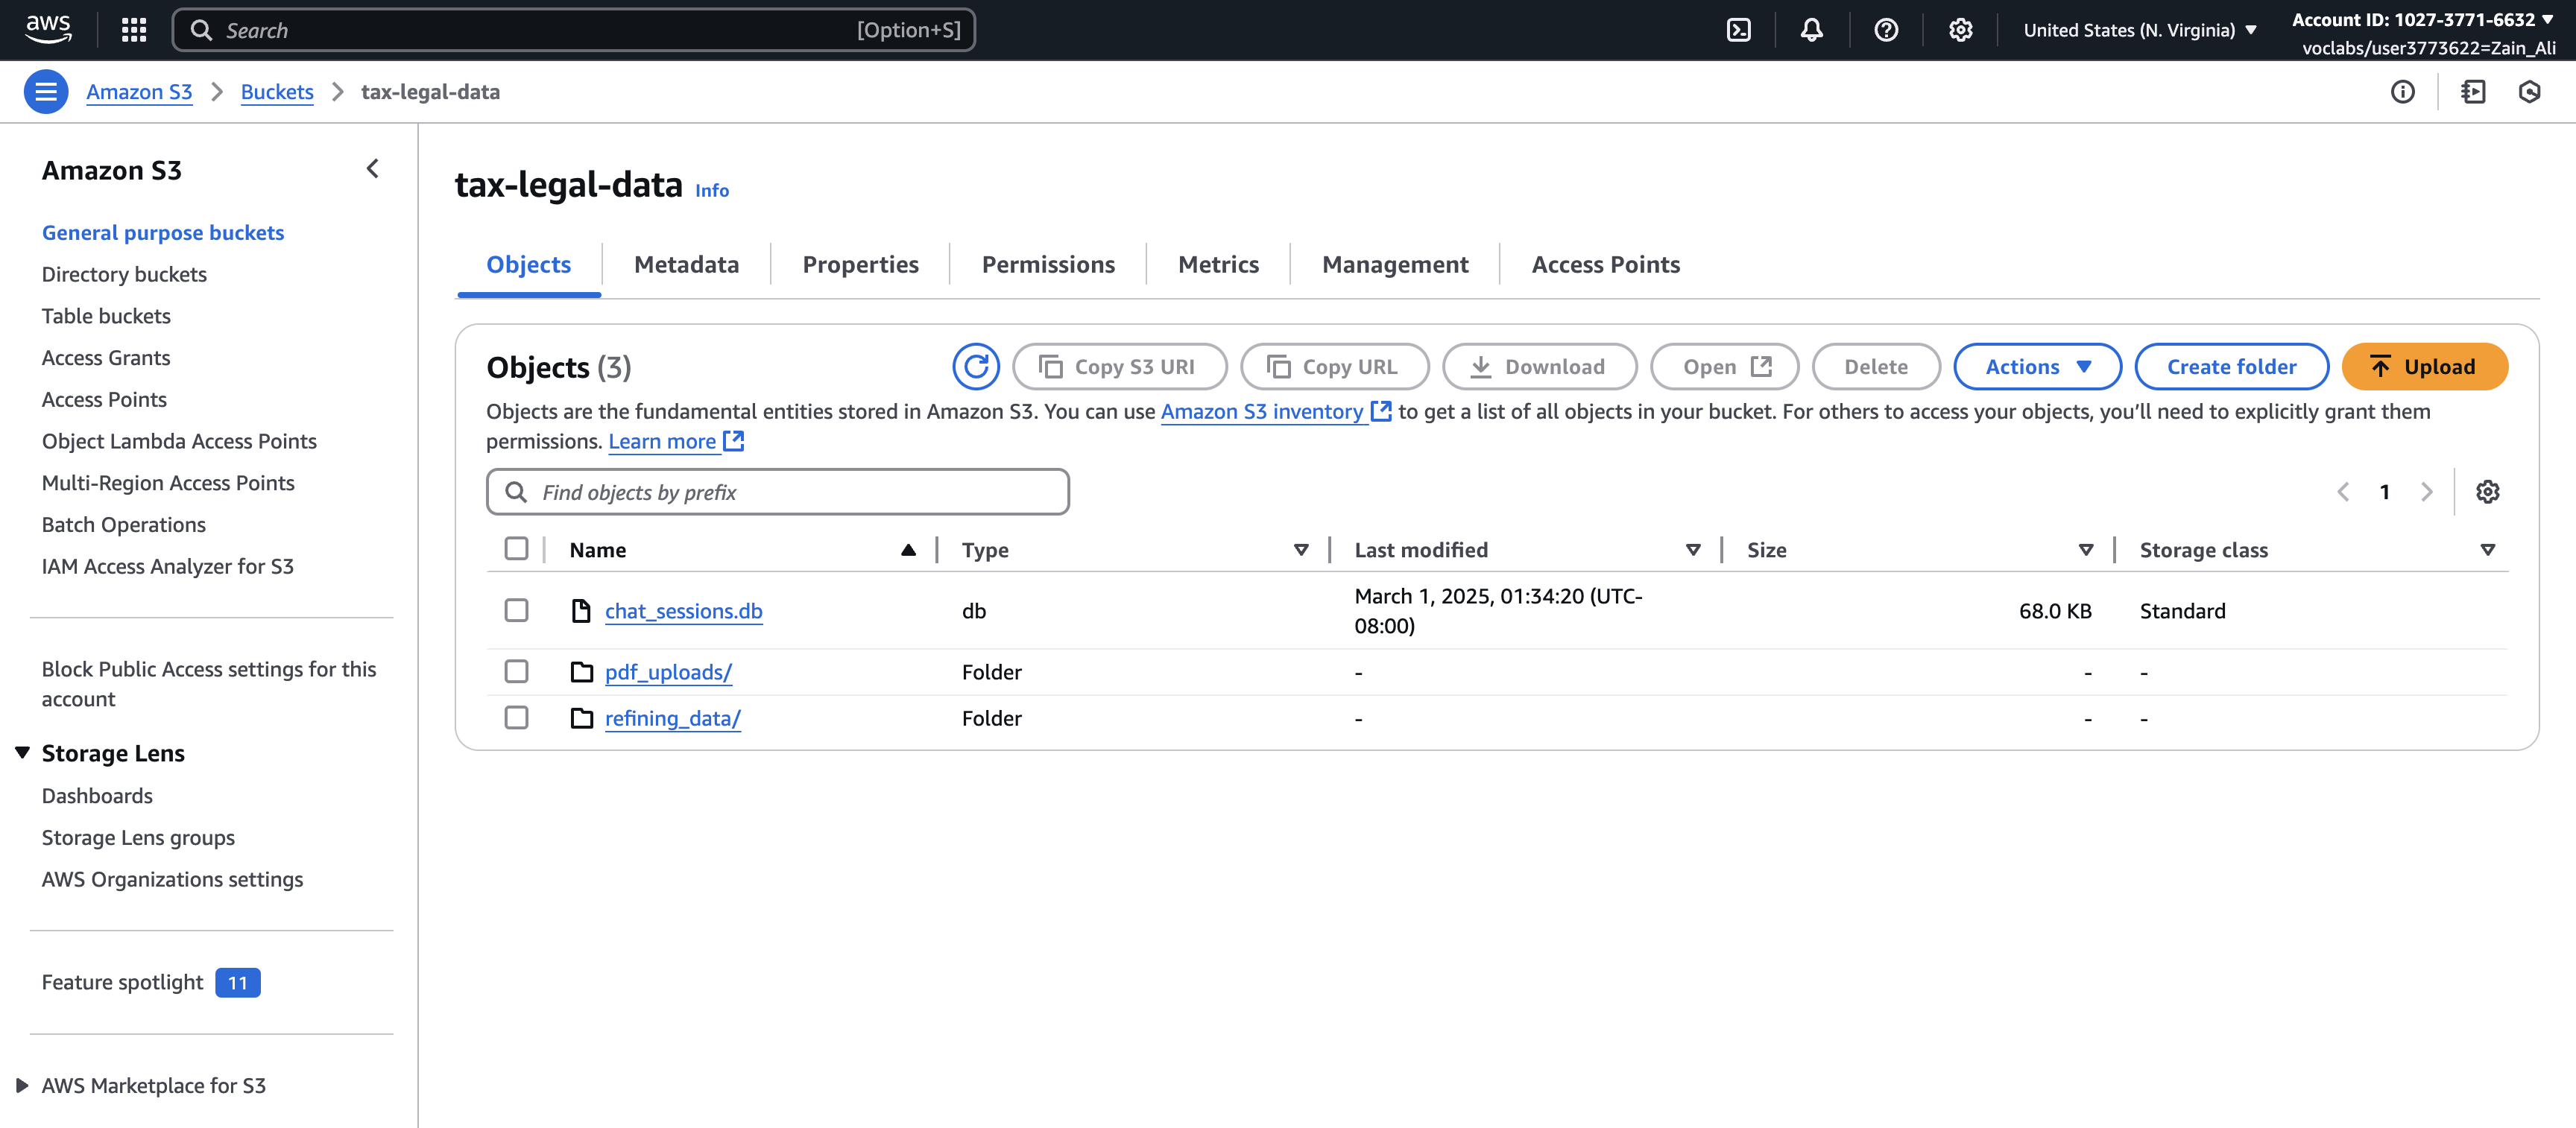

In [ ]:
display(Image.open("supporting_media/S3-screenshot.png"))

## Final Notes

TaxSense integrates a fine-tuned language model with Retrieval-Augmented Generation for accurate tax guidance. It securely stores chats, retrieves context from PDFs, and leverages Pinecone for external IRS data. The Gradio-based frontend provides a user-friendly dashboard, while a Flask-based backend manages model inference and data storage. Automated backups to AWS S3 are handled by our admin service.

For details on setup, deployment (including Docker), and usage, see the `README.md`. A demo video is also available there, showing you how to run and interact with the system step-by-step.